<h1>A Study of SARS-CoV-2</h1>
<h2>Objective of Experiment</h2>
The goal and objective of this experiment is to look at and compare results of SARS-CoV-2 across multiple countries and across each state. The data for this experiment comes from the John Hopkins University data repository, which gathers data from seven different sources and allows for it to be studied. This journal will try to compare this data not only to show the difference of how each government handled the virus, but to previous pandemics and the influenza.

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
from countryinfo import CountryInfo
import seaborn as sns

import glob
import us
import math

import copy
import random

import matplotlib
import matplotlib.pyplot as plt

import git
from collections import deque

import time
%matplotlib inline

<h2>Data File Location and Extraction</h2>
Set the location of data for cases collected by the Center for Sysem Science and Engineering (CSSE) for cases and deaths worldwide as well as data that has been collected for the United States. Goal will be to observe and compare the differences amongst a group of 15 countries (Brazil, Canada, China, Germany, Finland, India, Iran, Italy, Japan, South Korea, Norway, Switzerland, Spain, United Kingdom, United States) to each other and compare each state. The goal is to have a visible representation of the effects of the virus and compare how it has been handled across different governments with the amount of time they had to react. To pull and use the data that will be displayed in the following sections, please see README for the Johns Hopkins University data repository if unable to use the following code to clone or pull the data from the repository.

In [3]:
workingDir=os.getcwd()
try:
    updateCOVID=git.cmd.Git('COVID-19/')
    updateCOVID.pull()
except:
    try:
        git.Git(workingDir).clone('https://github.com/CSSEGISandData/COVID-19.git')
        print('Data Repository cloned and placed in working directory')
    except:
        print('Please ensure that you have a connection to the interent to either clone or pull in data directory')
else:
    print('Everything up-to-date')


Everything up-to-date


<h3>Extracting Data</h3>
Once this data is available for the systam DataFrames are created from reading the csv files for the number of cases, recoveries, and deaths for the United States and global. The first twenty-five rows of each dataset is provided for viewing, and visual verification that everything is correctly setup.

In [4]:
dataCSSEPath=r'COVID-19\csse_covid_19_data\csse_covid_19_time_series'

dataUSCases=pd.read_csv(dataCSSEPath + r'\time_series_covid19_confirmed_US.csv')
dataUSDeaths=pd.read_csv(dataCSSEPath + r'\time_series_covid19_deaths_US.csv')
dataGlobalCases=pd.read_csv(dataCSSEPath + r'\time_series_covid19_confirmed_global.csv')
dataGlobalDeaths=pd.read_csv(dataCSSEPath + r'\time_series_covid19_deaths_global.csv')

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
dataUSCases[0:25]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,310,312,312,313,314,314,314,314,319,319
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,33,33,36,36,37,37,37,37,38,38
3,63072001,PR,PRI,630,72001.0,Adjuntas,Puerto Rico,US,18.180117,-66.754367,...,63,66,66,66,66,67,68,72,72,72
4,63072003,PR,PRI,630,72003.0,Aguada,Puerto Rico,US,18.360255,-67.175131,...,54,57,58,60,60,66,67,70,71,75
5,63072005,PR,PRI,630,72005.0,Aguadilla,Puerto Rico,US,18.459681,-67.120815,...,82,84,84,85,89,97,102,110,112,120
6,63072007,PR,PRI,630,72007.0,Aguas Buenas,Puerto Rico,US,18.251619,-66.126806,...,68,69,69,72,72,73,77,80,81,82
7,63072009,PR,PRI,630,72009.0,Aibonito,Puerto Rico,US,18.131361,-66.264131,...,52,53,53,53,53,55,55,56,60,62
8,63072011,PR,PRI,630,72011.0,Anasco,Puerto Rico,US,18.287985,-67.120611,...,75,77,78,83,82,84,85,88,89,92
9,63072013,PR,PRI,630,72013.0,Arecibo,Puerto Rico,US,18.406631,-66.675077,...,151,162,162,161,167,172,174,182,186,189


In [6]:
dataUSDeaths[0:25]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,2,2,2,2,2,2,2,2,2,2
3,63072001,PR,PRI,630,72001.0,Adjuntas,Puerto Rico,US,18.180117,-66.754367,...,0,0,0,0,0,0,0,0,0,0
4,63072003,PR,PRI,630,72003.0,Aguada,Puerto Rico,US,18.360255,-67.175131,...,0,0,0,0,0,0,0,0,0,0
5,63072005,PR,PRI,630,72005.0,Aguadilla,Puerto Rico,US,18.459681,-67.120815,...,0,0,0,0,0,0,0,0,0,0
6,63072007,PR,PRI,630,72007.0,Aguas Buenas,Puerto Rico,US,18.251619,-66.126806,...,0,0,0,0,0,0,0,0,0,0
7,63072009,PR,PRI,630,72009.0,Aibonito,Puerto Rico,US,18.131361,-66.264131,...,0,0,0,0,0,0,0,0,0,0
8,63072011,PR,PRI,630,72011.0,Anasco,Puerto Rico,US,18.287985,-67.120611,...,0,0,0,0,0,0,0,0,0,0
9,63072013,PR,PRI,630,72013.0,Arecibo,Puerto Rico,US,18.406631,-66.675077,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dataGlobalCases[0:25]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,34451,34455,34740,34994,35070,35229,35301,35475,35526,35615
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,3454,3571,3667,3752,3851,3906,4008,4090,4171,4290
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,19195,19689,20216,20770,21355,21948,22549,23084,23691,24278
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,855,858,861,862,877,880,880,880,884,884
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,506,525,541,576,607,638,687,705,749,779
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,74,74,74,74,74,76,76,76,76,76
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,100166,103265,106910,111146,114783,119301,122524,126755,130774,136118
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,31969,32151,32490,33005,33559,34001,34462,34877,34981,35254
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,113,113,113,113,113,113,113,113,113,113
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,...,3492,3505,3517,3527,3535,3550,3568,3588,3599,3614


In [8]:
dataGlobalDeaths[0:25]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,93,95,97,101,104,107,111,112,113,117
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,26,26,26,27,28,29,29,29,29,30
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,1845,1903,1968,2050,2112,2178,2220,2260,2373,2490
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,565,573,581,592,607,620,631,641,650,662
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,0,0,...,49,49,49,49,49,49,49,49,49,49


<h2>Creating Methods for States</h2>
The following methods provided below will be used to create the plots that will be used to display the number of cases, recoveries, deaths, and mortality rates in the United States tracked since the 21st of Janurary. Each method defined here will be able to either take in a single state to be used as a case study, or plot each state to do side-by-side comparisons.

In [9]:
def plotCasesByState(state=None, logScale=False, byPopDensity=False, popDensity=100000):
    i=0
    maxCases=0
    plt.clf()
    if byPopDensity:
        return
    else:
        if(state==None):
            states = us.states.STATES
            rows=10
            cols=math.ceil(len(states)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            fig.suptitle('Number of Cases for SARS-CoV-2 by State in the United States')
            i=0
            for state in states:
                data=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
                if(i%5==0):
                    axs[int(i/cols),i%cols].set_ylabel('Cases')
                if(int(i/cols)==rows-1):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-CoV-2')
                if logScale:
                    data=np.log(data)
                    data[data==math.nan]=0
                    if(i%5==0):
                        axs[int(i/cols),i%cols].set_ylabel('log(Cases)')
                axs[int(i/cols), i%cols].plot(data)
                axs[int(i/cols),i%cols].set_title('Cases in ' + state.name)
                i+=1
                if np.max(np.max(data)) > maxCases:
                    maxCases=np.max(np.max(data))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxCases])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])

        else:
            data=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
            if logScale:
                data=np.log(data)
                data[data==math.nan]=0
            plt.title(state)
            plt.ylabel('Number of Cases for SARS-CoV-2')
            plt.xlabel('Day of SARS-CoV-2')
            plt.plot(data)
        
    plt.show()

In [10]:
def plotDeathsByState(state=None, logScale=False, byPopDensity=False, popDensity=100000):
    i=0
    maxDeaths=0
    plt.clf()
    if byPopDensity:
        return
    else:
        if(state==None):
            states = us.states.STATES
            rows=10
            cols=math.ceil(len(states)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            fig.suptitle('Number of Deaths for SARS-CoV-2 by State in the United Statets')
            i=0
            for state in states:
                data=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Deaths')
                if(int(i/cols)==rows-1):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-CoV-2')
                if logScale:
                    data=np.log(data)
                    data[data==math.nan]=0
                    if(i%cols==0):
                        axs[int(i/cols),i%cols].set_ylabel('log(Deaths)')
                axs[int(i/cols), i%cols].plot(data)
                axs[int(i/cols), i%cols].set_title('Deaths in ' + state.name)
                i+=1
                if np.max(np.max(data)) > maxDeaths:
                    maxDeaths=np.max(np.max(data))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxDeaths])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])

        else:
            data=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
            if logScale:
                data=np.log(data)
                data[data==math.nan]=0
            plt.title(state)
            plt.ylabel('Number of Deaths for SARS-CoV-2')
            plt.xlabel('Day of SARS-CoV-2')
            plt.plot(data)
        
    plt.show()

In [12]:
def plotMortalityRateByState(state=None):
    i=0
    maxRate=0
    plt.clf()
    if(state==None):
        states = us.states.STATES
        rows=10
        cols=math.ceil(len(states)/rows)
        fig, axs = plt.subplots(rows,cols,figsize=(20,40))
        i=0
        fig.suptitle('Mortality Rate of SARS-CoV-2 by State in the United States', fontsize='xx-large')
        for state in states:
            cases=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
            deaths=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
            data=deaths/cases*100
            axs[int(i/cols), i%cols].plot(data)
            axs[int(i/cols), i%cols].set_title('Mortality Rate in ' + state.name)
            if(i%cols==0):
                axs[int(i/cols),i%cols].set_ylabel('Mortality Rate (%)')
            if(int(i/cols)==rows-1):
                axs[int(i/cols),i%cols].set_xlabel('Day of SARS-CoV-2')
            i+=1
            if np.max(np.max(data)) > maxRate:
                maxRate=np.max(np.max(data))

        for ax in axs.flat:
            ax.set_ylim([0, 1.1*maxRate])

        fig.tight_layout(rect=[0,0.3,1,0.95])

    else:
        cases=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
        deaths=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
        data=deaths/cases*100
        plt.title('Mortality Rate of SARS-CoV-2' + state.name)
        plt.ylabel('Mortality Rate (%)')
        plt.xlabel('Day of SARS-CoV-2')
        plt.plot(data)
        
    plt.show()

<h2>Creating Methods for Countries</h2>
Similar to the methods that are used for creating the plots that will be used for a state-by-state comparison, the same will be done to either show off a country for a case study or compare one of the ten listed above for a comparison to how well each of the countries were able to handle the virus.

In [58]:
def plotCasesByCountry(country, logScale=False, byPopulationDensity=False, populationDensity=100000000):
    if len(country)>1:
        maxCases=0
        rows=5
        cols=math.ceil(len(country)/rows)
        if cols>rows:
            rows=cols
            cols=5
        fig, axs = plt.subplots(rows,cols,figsize=(20,40))
        i=0
        if logScale:
            fig.suptitle('log(Cases) of SARS-CoV-2', fontsize='xx-large')
        elif byPopulationDensity:
            fig.suptitle('Number of Cases per ' + str(populationDensity) + ' people of SARS-CoV-2', fontsize='xx-large')
        else:
            fig.suptitle('Number of Cases of SARS-CoV-2', fontsize='xx-large')
        for cntry in country:
            cases=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==cntry].T[11:], axis=1))
            if(i%cols==0):
                axs[int(i/cols),i%cols].set_ylabel('Cases')
            if(int(i/cols)==rows-1):
                axs[int(i/cols),i%cols].set_xlabel('Day of SARS-CoV-2')
            if logScale:
                cases=np.log(cases)
                cases[cases==math.nan]=0
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('log(Cases)')
            elif byPopulationDensity:
                if cntry=='US':
                    cntry='United States'
                elif cntry=='Korea, South':
                    cntry='South Korea'
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Cases per ' + str(populationDensity) + ' people')
                countryInfo=CountryInfo(cntry)
                deaths=populationDensity*cases/countryInfo.info()['population']

            axs[int(i/cols), i%cols].plot(cases)
            axs[int(i/cols), i%cols].set_title('Cases in ' + cntry)
            i+=1
            if np.max(np.max(cases)) > maxCases:
                maxCases=np.max(np.max(cases))

        for ax in axs.flat:
            ax.set_ylim([0, 1.1*maxCases])

        fig.tight_layout(rect=[0,0.3,1,0.95])
    else:
        data=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==country].T[11:], axis=1))
        plt.title(country)
        plt.ylabel('Cases')
        plt.xlabel('Day of SARS-CoV-2')
        plt.plot(data)
        
    plt.show()
    return cases

In [59]:
def plotDeathsByCountry(country, logScale=False, byPopulationDensity=False, populationDensity=100000000):
    if len(country)>1:
        maxDeaths=0
        rows=5
        cols=math.ceil(len(country)/rows)
        if cols>rows:
            rows=cols
            cols=5
        fig, axs = plt.subplots(rows,cols,figsize=(20,40))
        i=0
        if logScale:
            fig.suptitle('log(Deaths) for SARS-CoV-2', fontsize='xx-large')
        elif byPopulationDensity:
            fig.suptitle('Number of Deaths per ' + str(populationDensity) + ' people for SARS-CoV-2', fontsize='xx-large')
        else:
            fig.suptitle('Number of Deaths for SARS-CoV-2', fontsize='xx-large')
        for cntry in country:
            deaths=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==cntry].T[11:], axis=1))
            if(i%cols==0):
                axs[int(i/cols),i%cols].set_ylabel('Deaths')
            if(int(i/cols)==4):
                axs[int(i/cols),i%cols].set_xlabel('Day of SARS-CoV-2')
            if logScale:
                deaths=np.log(deaths)
                deaths[deaths==math.nan]=0
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('log(Deaths)')
            elif byPopulationDensity:
                if cntry=='US':
                    cntry='United States'
                elif cntry=='Korea, South':
                    cntry='South Korea'
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Deaths per ' + str(populationDensity) + ' people')
                deaths=populationDensity*deaths/CountryInfo(cntry).info()['population']
                
            axs[int(i/cols), i%cols].plot(deaths)
            axs[int(i/cols), i%cols].set_title('Deaths in ' + cntry)
            i+=1
            if np.max(np.max(deaths)) > maxDeaths:
                maxDeaths=np.max(np.max(deaths))

        for ax in axs.flat:
            ax.set_ylim([0, 1.1*maxDeaths])

        fig.tight_layout(rect=[0,0.3,1,0.95])
    else:
        data=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==country].T[11:], axis=1))
        plt.title(country)
        plt.ylabel('Deaths')
        plt.xlabel('Day of SARS-CoV-2')
        plt.plot(data)
        
    plt.show()
    return deaths

In [55]:
def plotMortalityByCountry(country=None):    
    if len(country)>1:
        maxRate=0
        rows=5
        cols=math.ceil(len(country)/rows)
        if cols>rows:
            rows=cols
            cols=5
        fig, axs = plt.subplots(rows,cols,figsize=(20,40))
        i=0
        fig.suptitle('Mortality Rate for SARS-CoV-2', fontsize='xx-large')
        for cntry in country:
            cases=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==cntry].T[11:], axis=1))
            deaths=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==cntry].T[11:], axis=1))
            rate=deaths/cases
            axs[int(i/cols), i%cols].plot(rate)
            axs[int(i/cols), i%cols].set_title('Mortality Rate in ' + cntry)
            if(i%cols==0):
                axs[int(i/cols),i%cols].set_ylabel('Mortality Rate (%)')
            if(int(i/cols)==rows-1):
                axs[int(i/cols),i%cols].set_xlabel('Day of SARS-CoV-2')
            i+=1
            if np.max(np.max(rate)) > maxRate:
                maxRate=np.max(np.max(rate))

        for ax in axs.flat:
            ax.set_ylim([0, 1.1*maxRate])

        fig.tight_layout(rect=[0,0.3,1,0.95])
    else:
        cases=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==country].T[11:], axis=1))
        deaths=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==country].T[11:], axis=1))
        rate=deaths/cases
        plt.title(country)
        plt.ylabel('Mortality Rate for SARS-CoV-2')
        plt.xlabel('Day of SARS-CoV-2')
        plt.plot(rate)
        
    plt.show()
    return rate


<h2>Graphing Results</h2>
The following sections will contain the graphs based on the data provided by Johns Hopkins University. The first set show the number of cases, deaths, and rate of mortality in the United States as we have gotten further into the pandemic. After each section I will comment on some of the key states that have been of media publicity: Georgia, Florida, Arizona, New York, Texas, Washington, and California.
<h3>Time Series Data</h3>
<h4>Results by State</h4>
Display the data for each state. The first set of plots will have the raw data for the number of cases, deaths, and mortality rate of SARS-COVID-2 based on the data provided by the CSSE from Johns Hopkins University. After this data is plotted, it is scaled and show the logarithmic scaling of the data. This helps to show the rise in number of cases and deaths in each state that had smaller numbers compared to the New York. These plots help to illustrate how well each state was able to get a handle on the virus.
<h4>Raw Data</h4>

<Figure size 432x288 with 0 Axes>

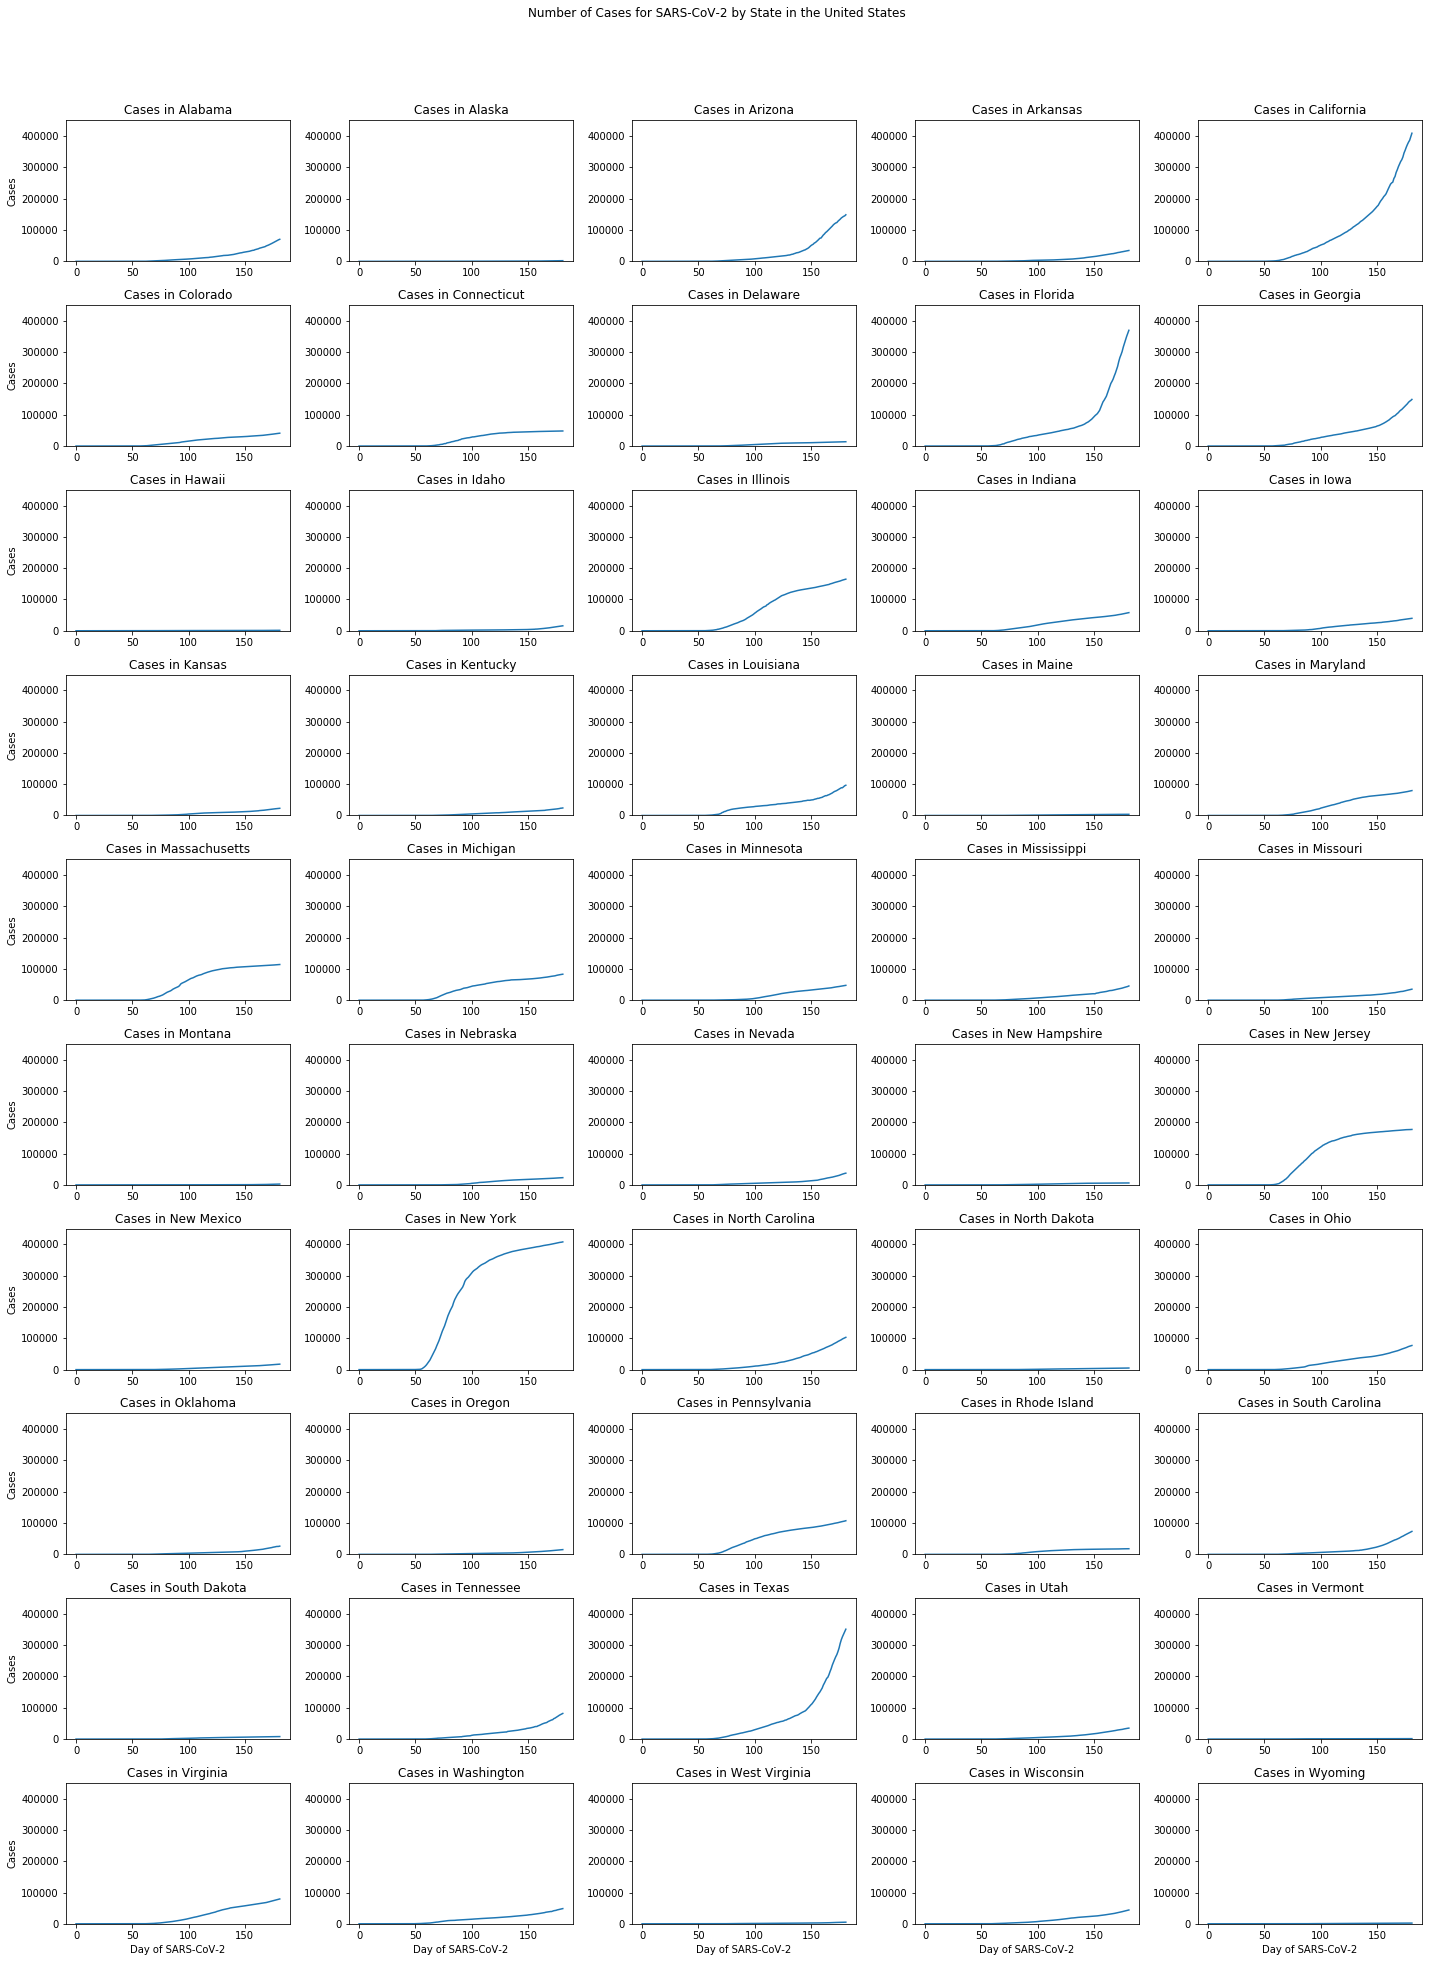

In [41]:
plotCasesByState()

<Figure size 432x288 with 0 Axes>

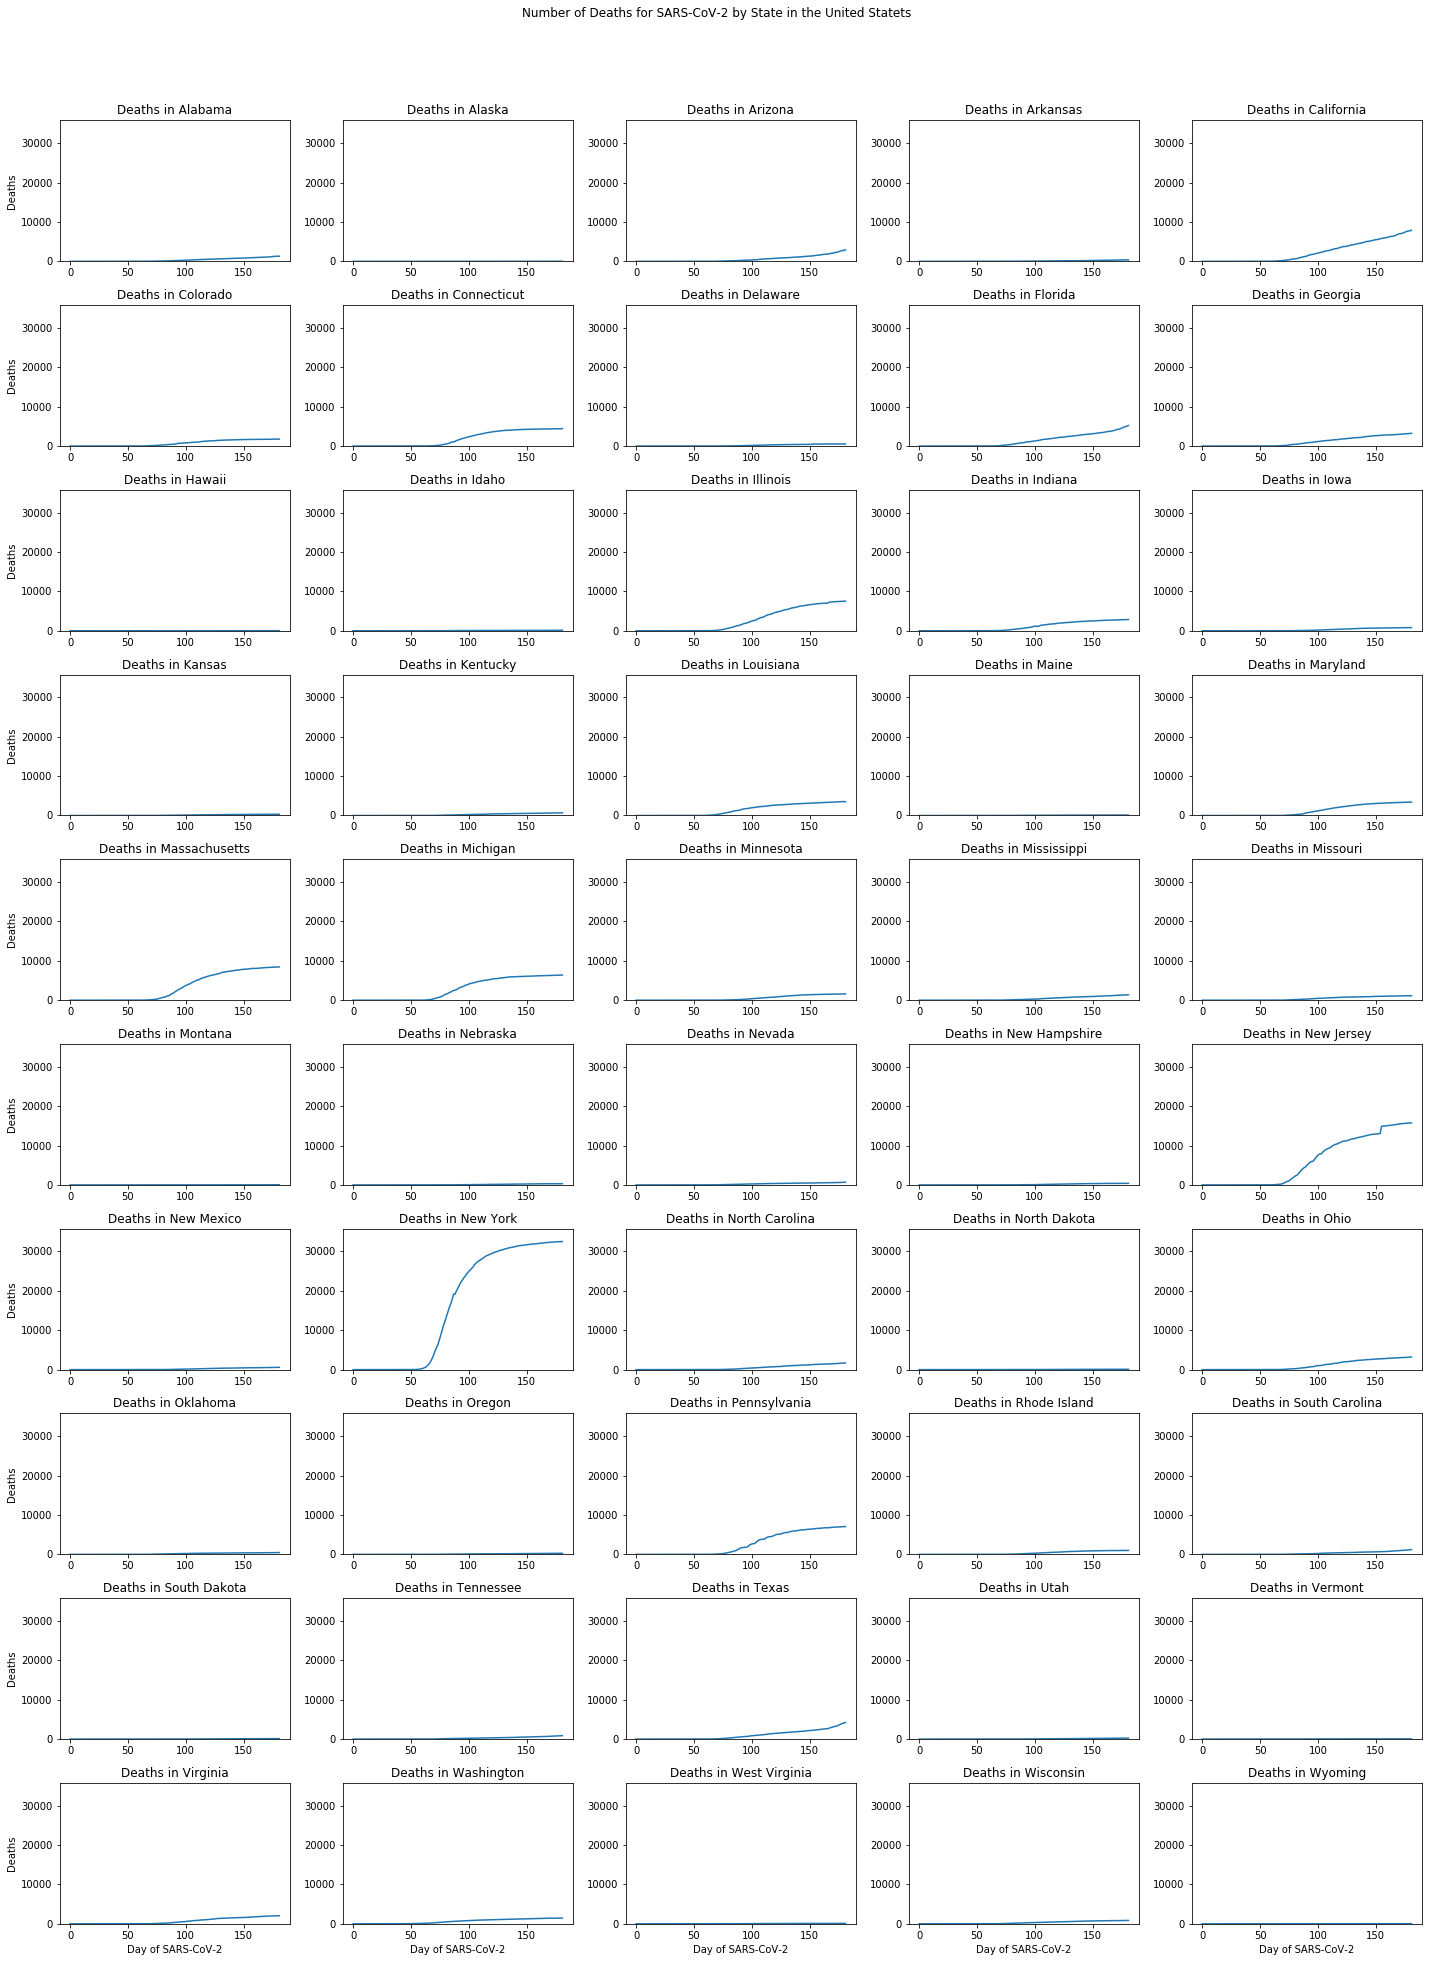

In [42]:
plotDeathsByState()

<Figure size 432x288 with 0 Axes>

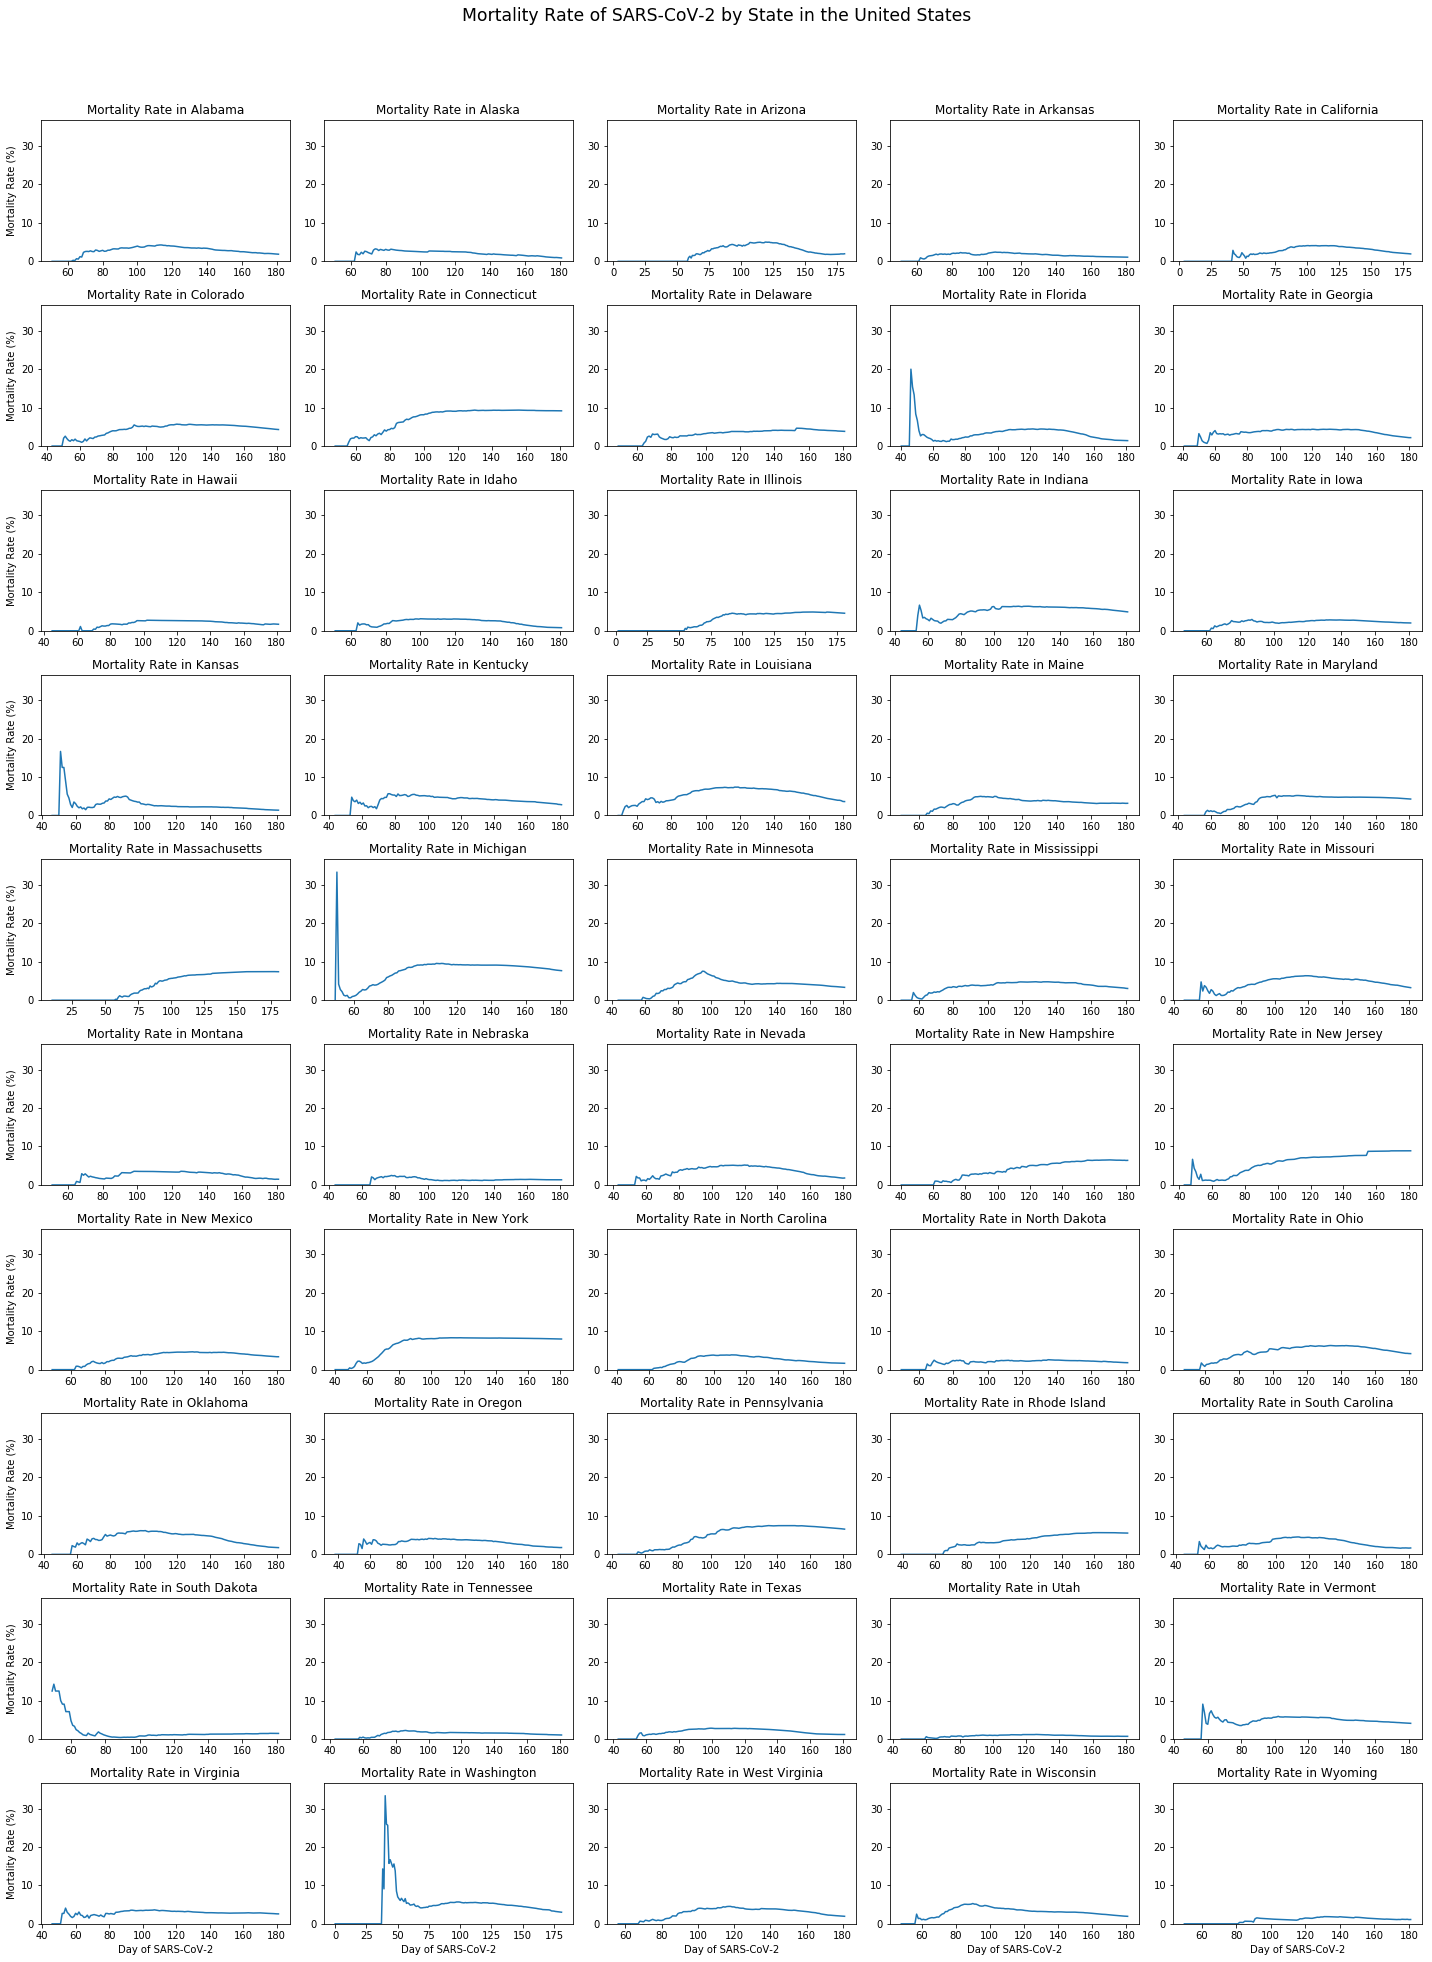

In [43]:
plotMortalityRateByState()

<h4>Observations</h4>

<h4>Scaling the data by log scale</h4>

<Figure size 432x288 with 0 Axes>

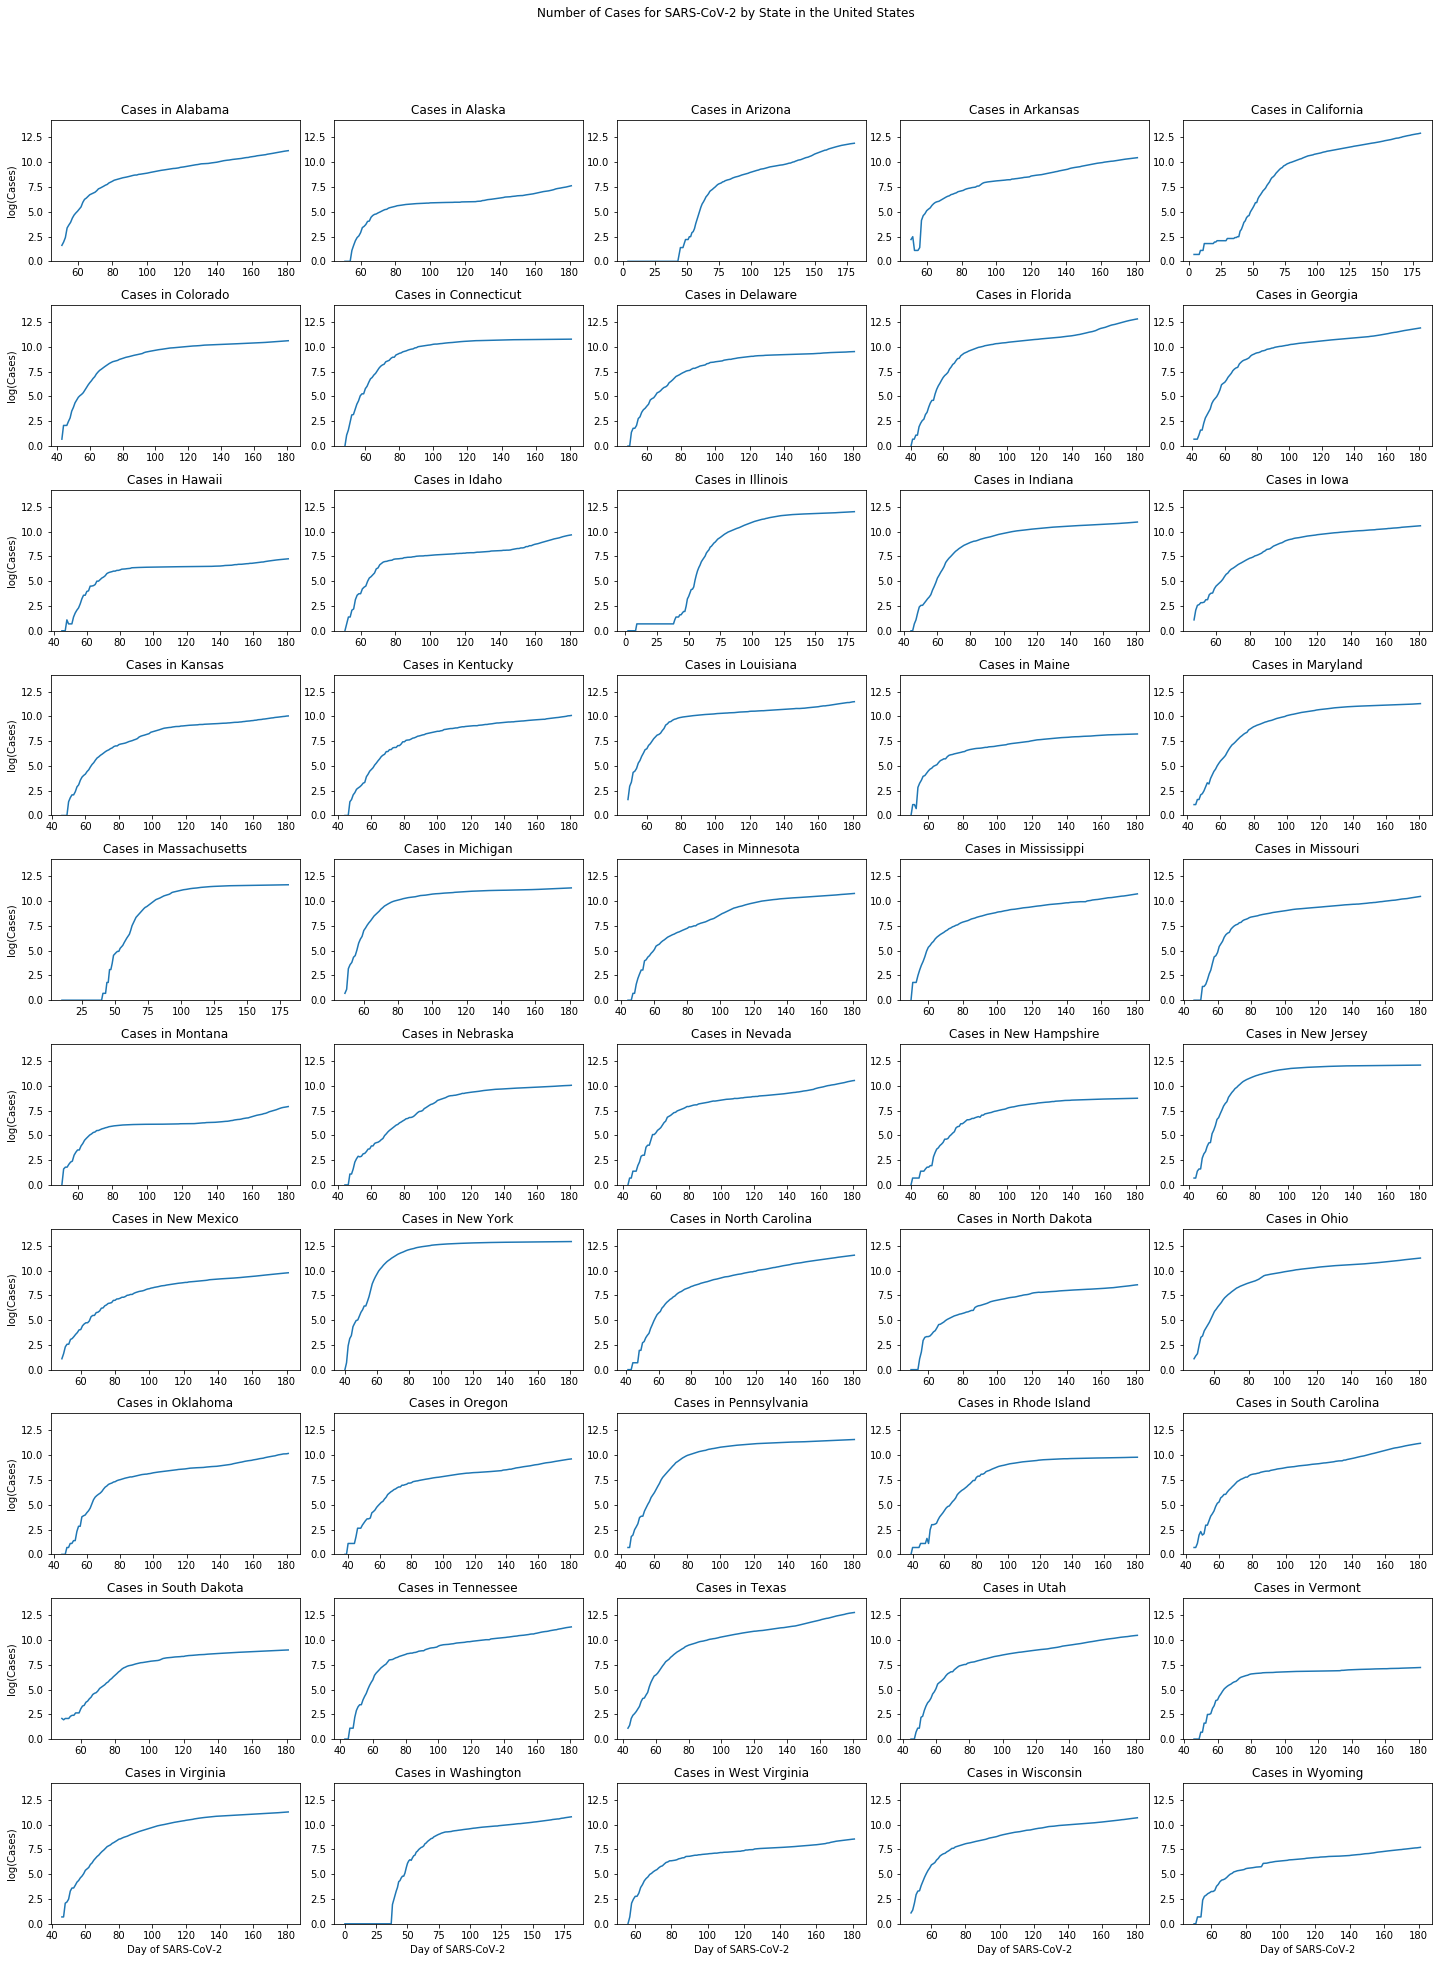

In [17]:
plotCasesByState(logScale=True)

<Figure size 432x288 with 0 Axes>

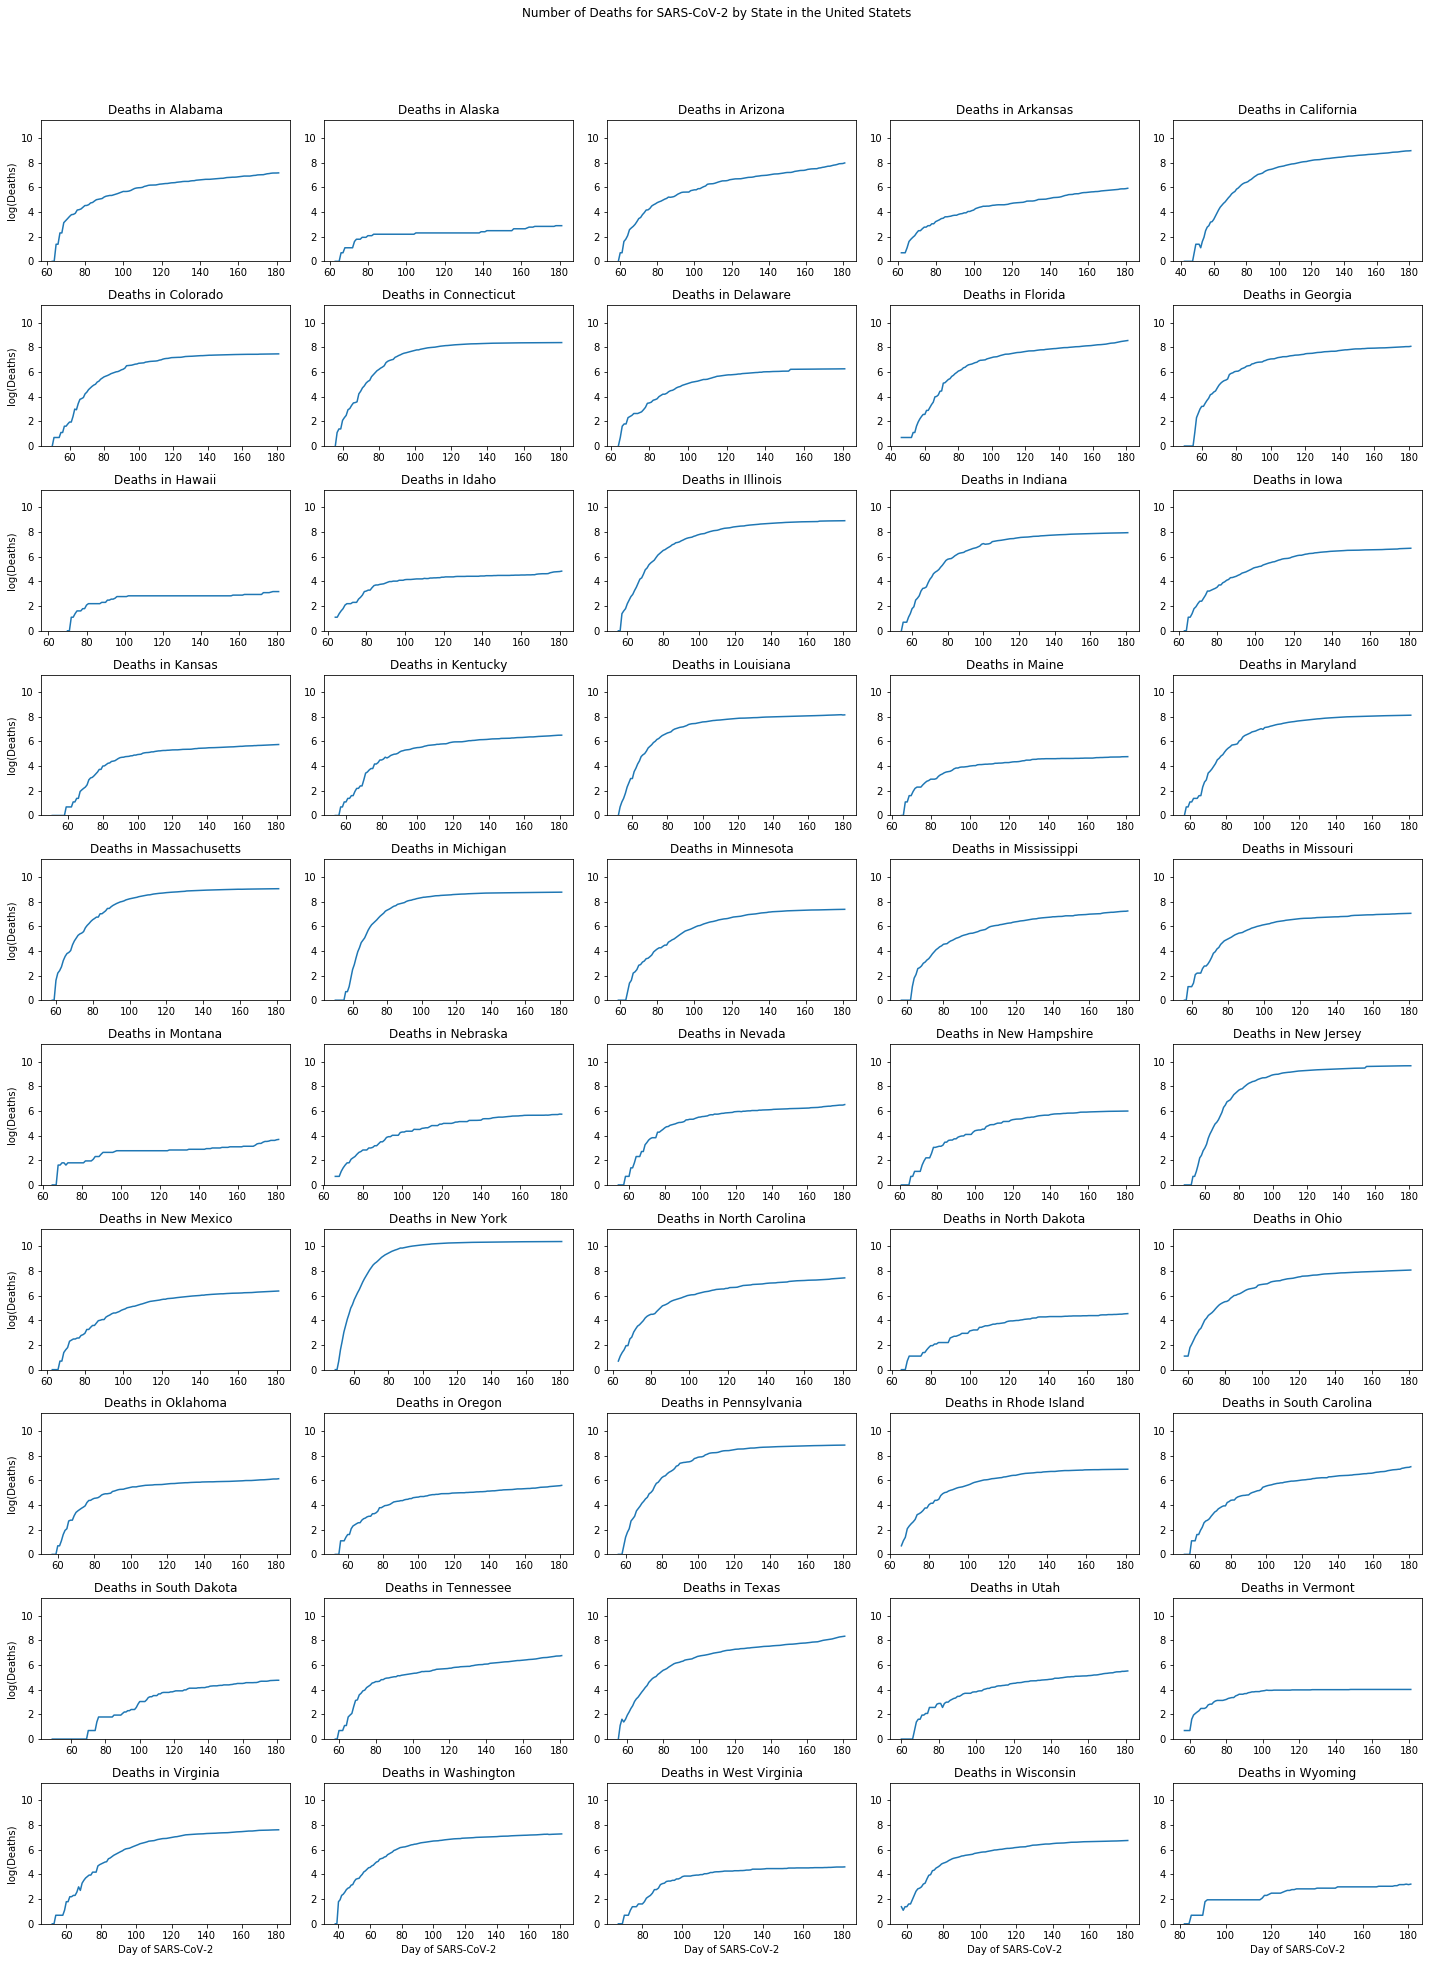

In [18]:
plotDeathsByState(logScale=True)

<h4>Observations</h4>

<h4>Results by Country</h4>
Display th data for each of the listed countries. The first set of plots will have the raw data for the number of cases, deaths, and mortality rate of SARS-COVID-2 based on the data provided by the CSSE from Johns Hopkins University. After this data is plotted, it will be scaled and show the logarithmic scaling of the data. This helps to show the rise in number of cases and deaths in each country that had smaller numbers compared to the United States. These plots help to illustrate how well a country was able to get a handle on the virus.

In [16]:
# List of countries of interest
countries = [ 'Brazil', 'Canada', 'China', 'Germany', 'Finland',
             'India', 'Iran', 'Italy', 'Japan', 'Korea, South',
             'Norway', 'Switzerland', 'Spain', 'United Kingdom', 'US'
            ]

<h4>Raw Data</h4>

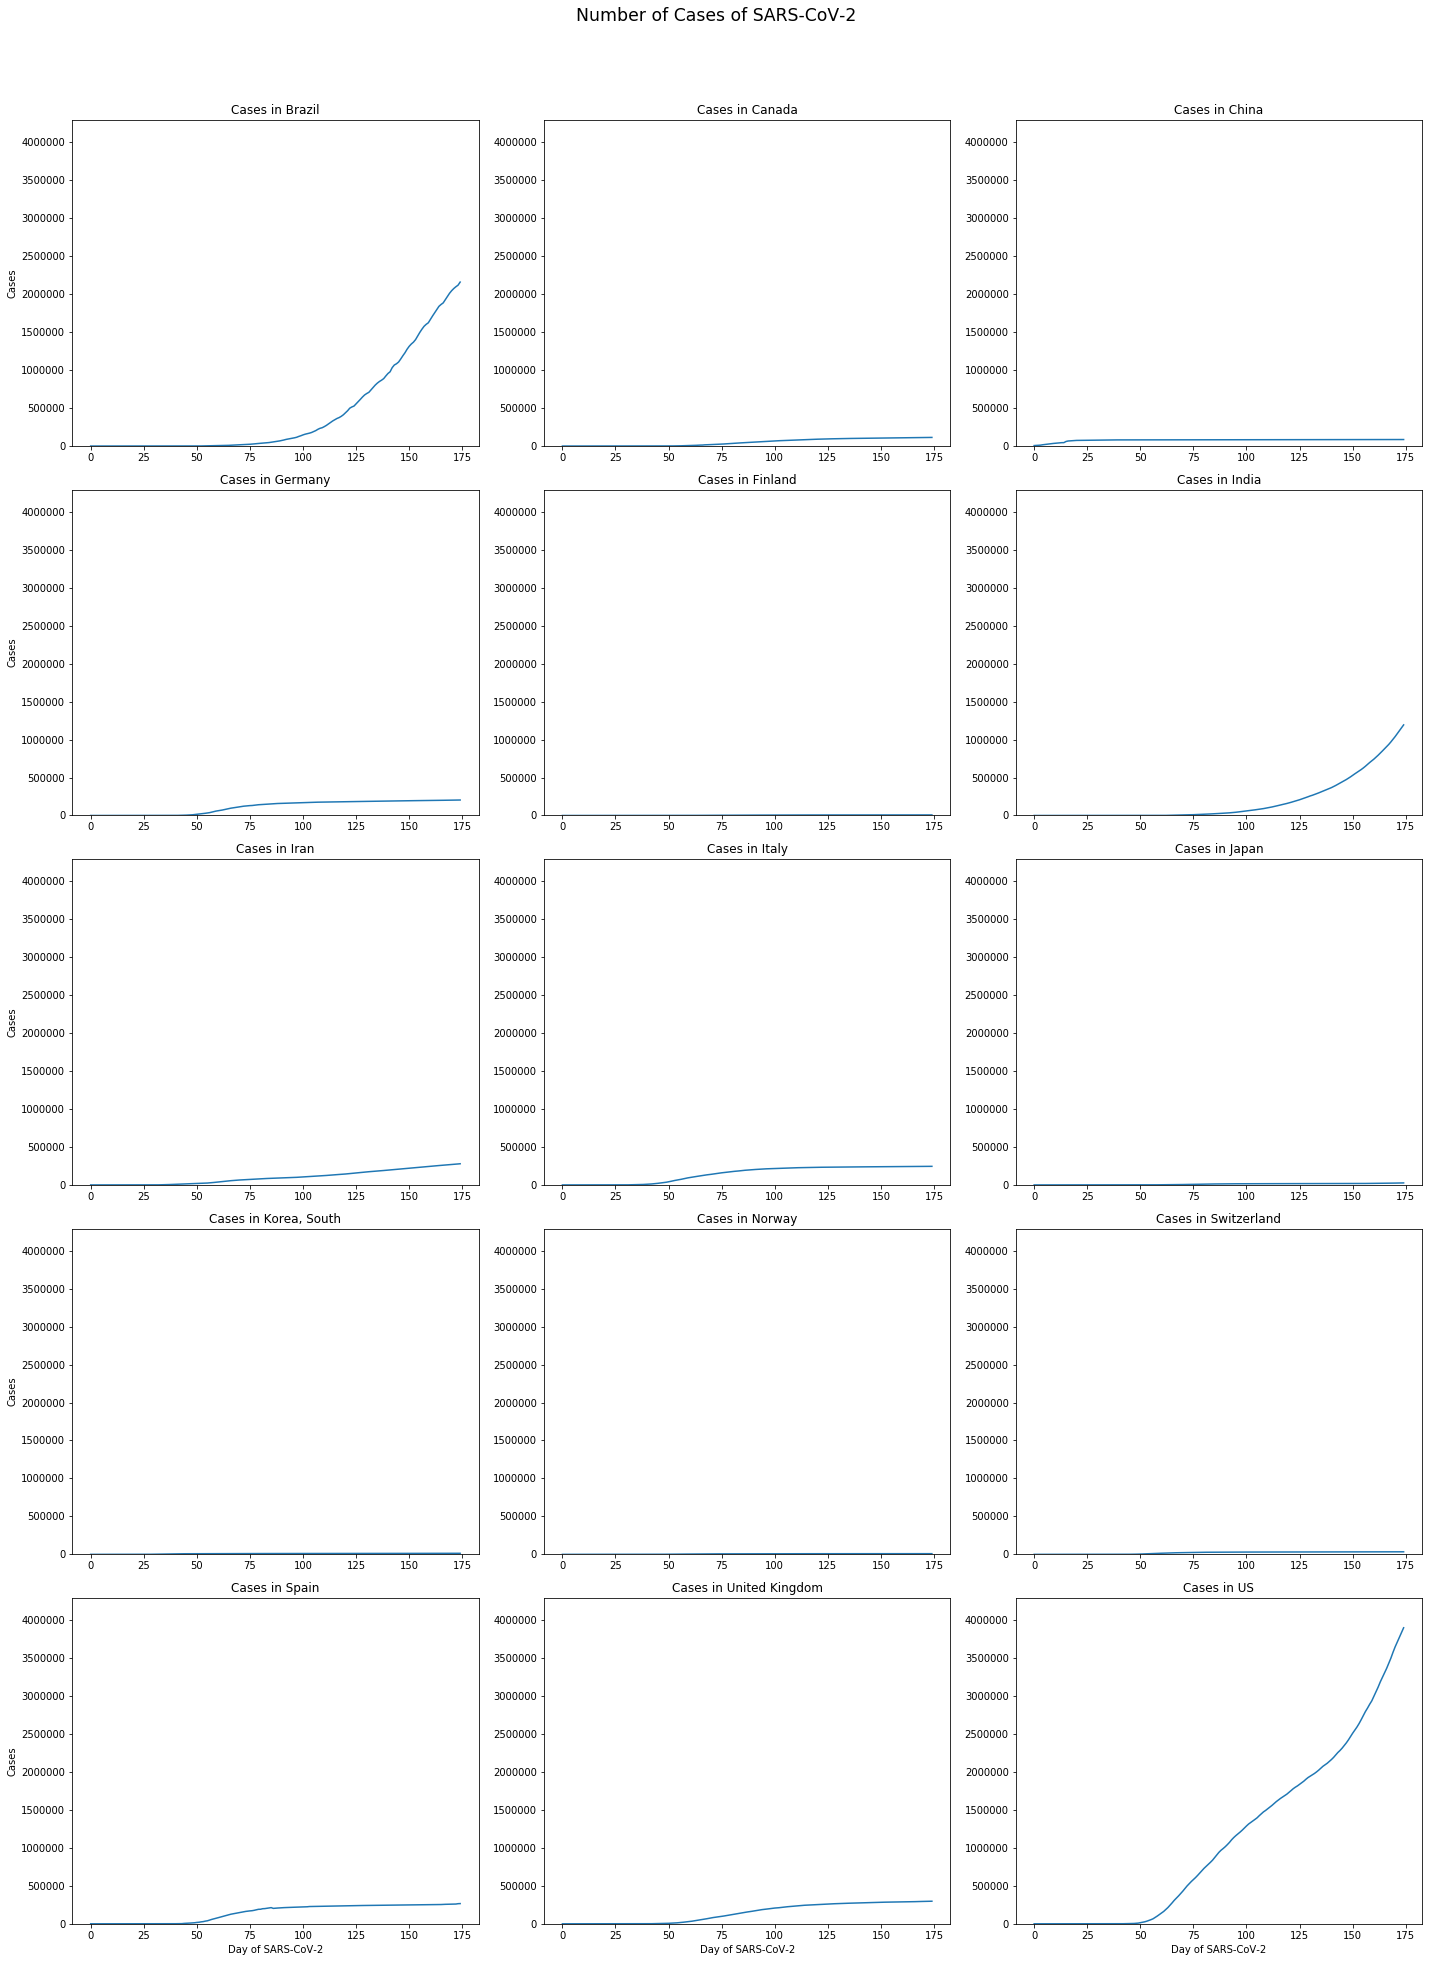

In [17]:
rawCases=plotCasesByCountry(countries)

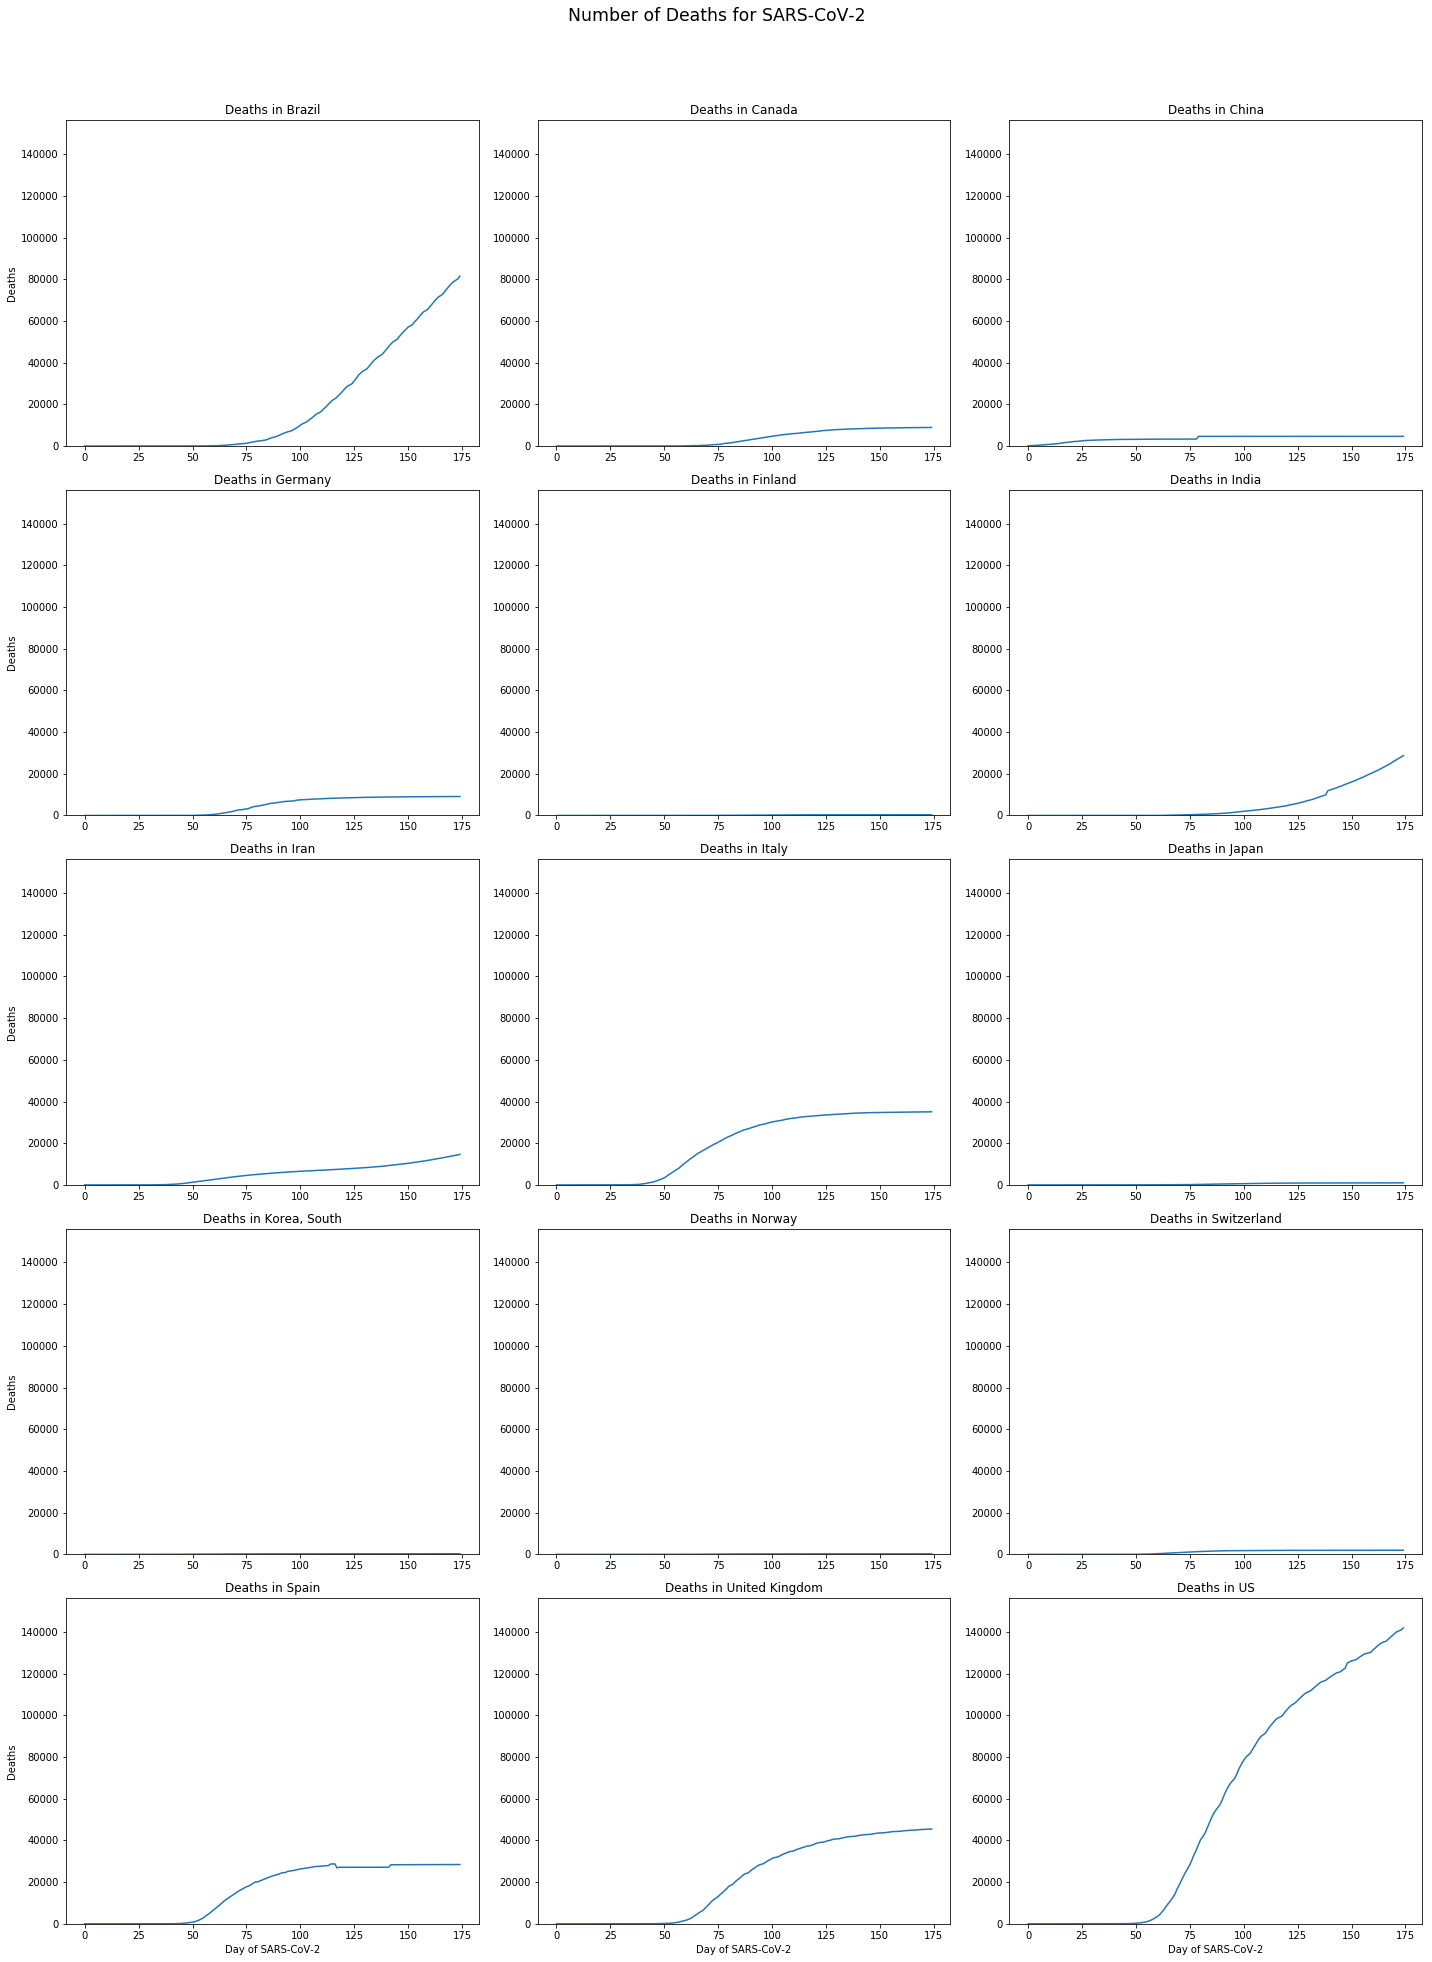

In [28]:
rawDeaths=plotDeathsByCountry(countries)

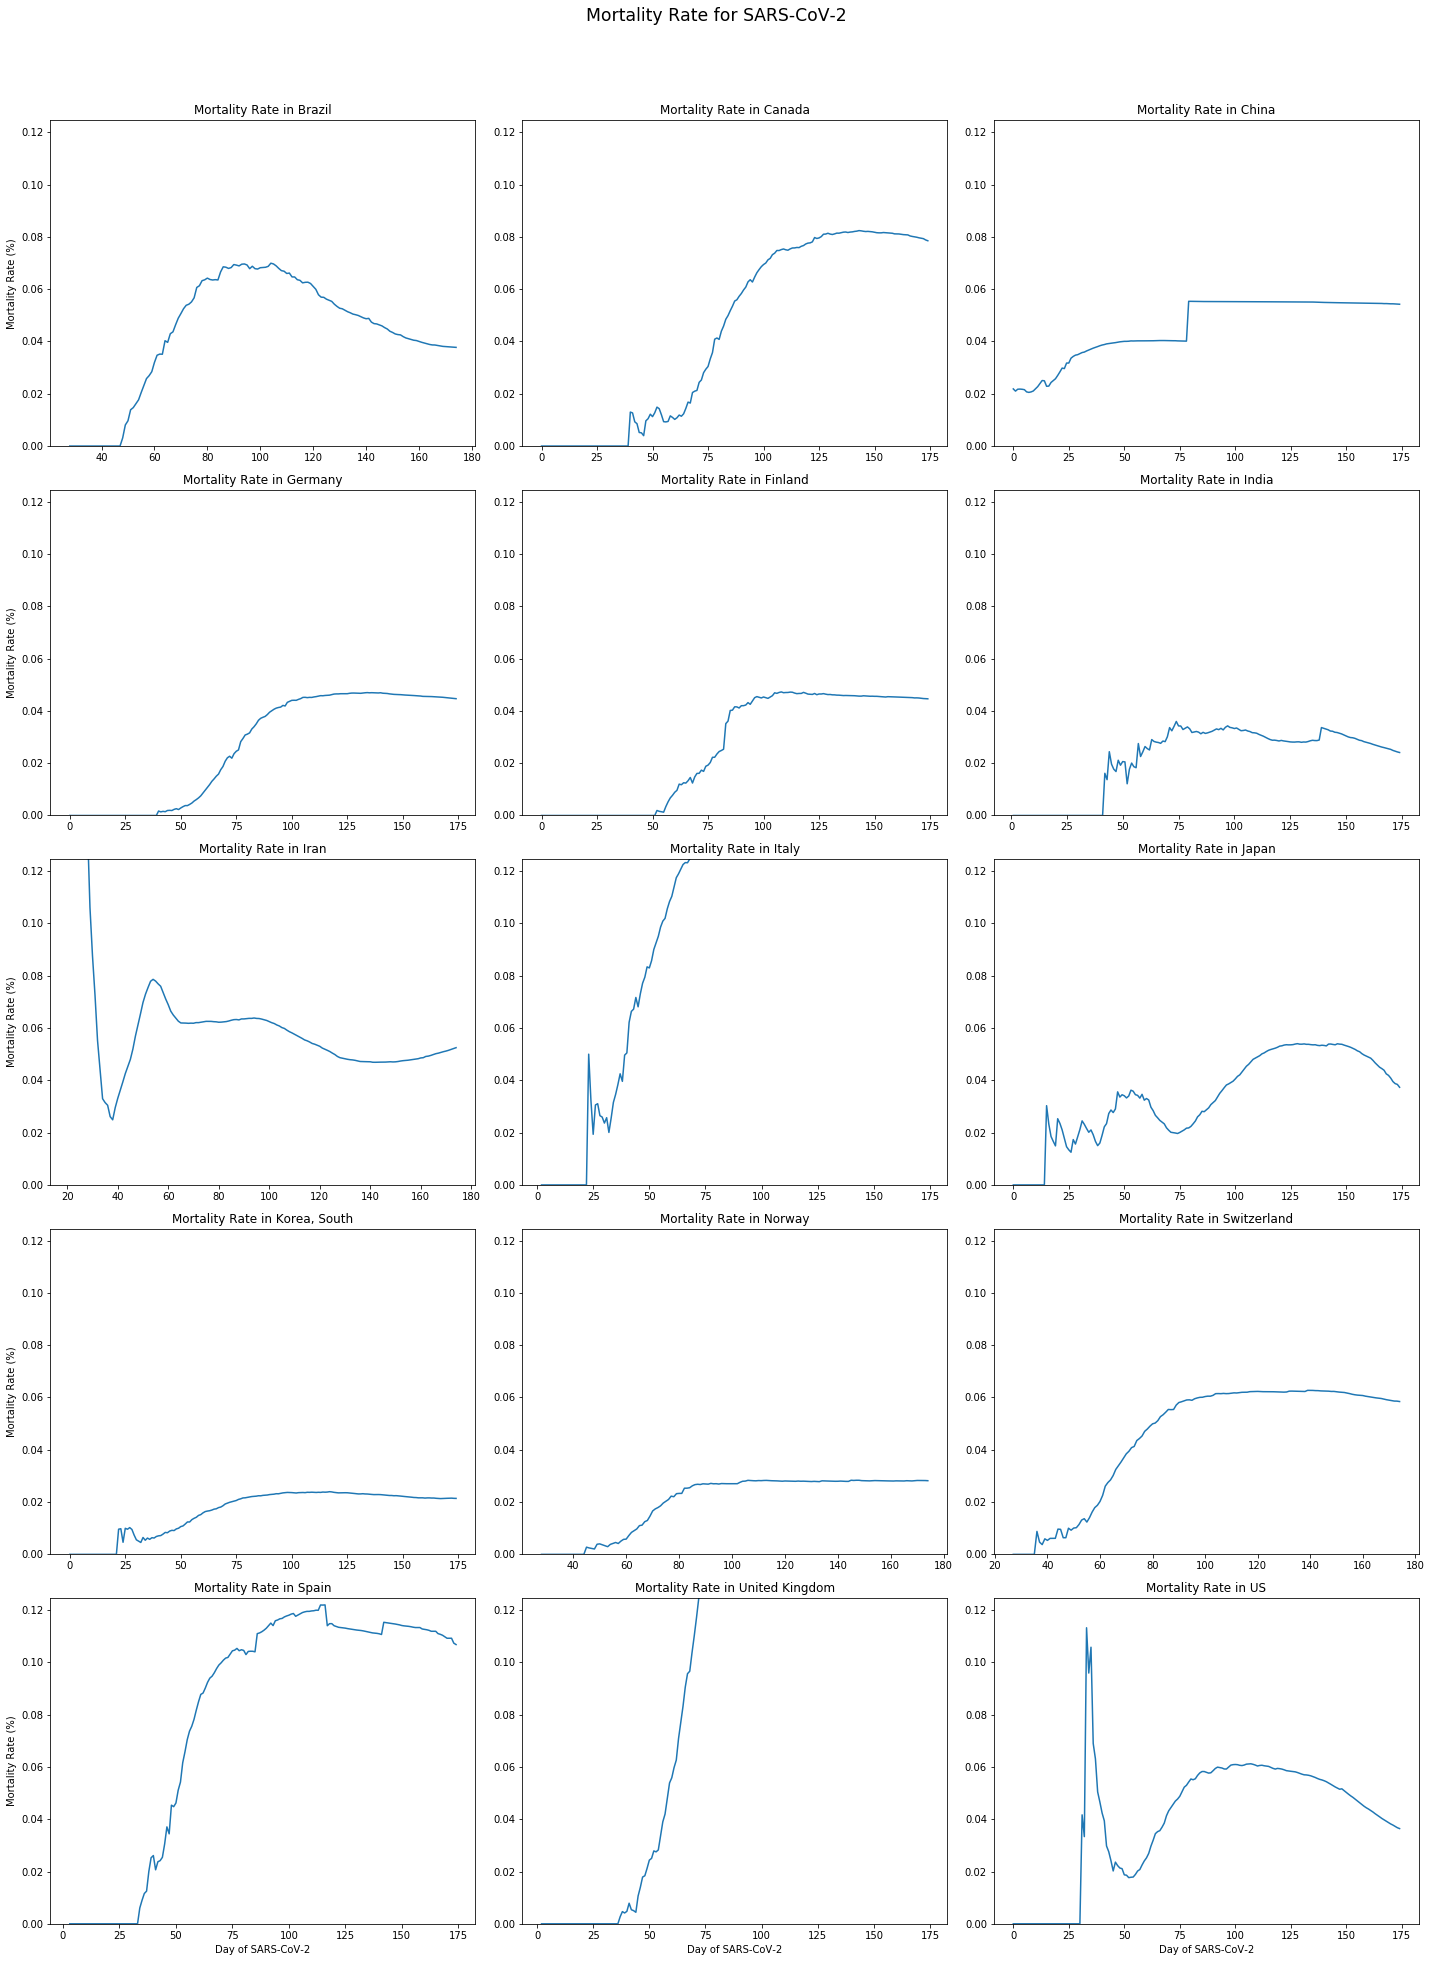

In [19]:
rawMortality=plotMortalityByCountry(countries)

<h4>Observations</h4>

<h4>Scaling the data by log scale</h4>

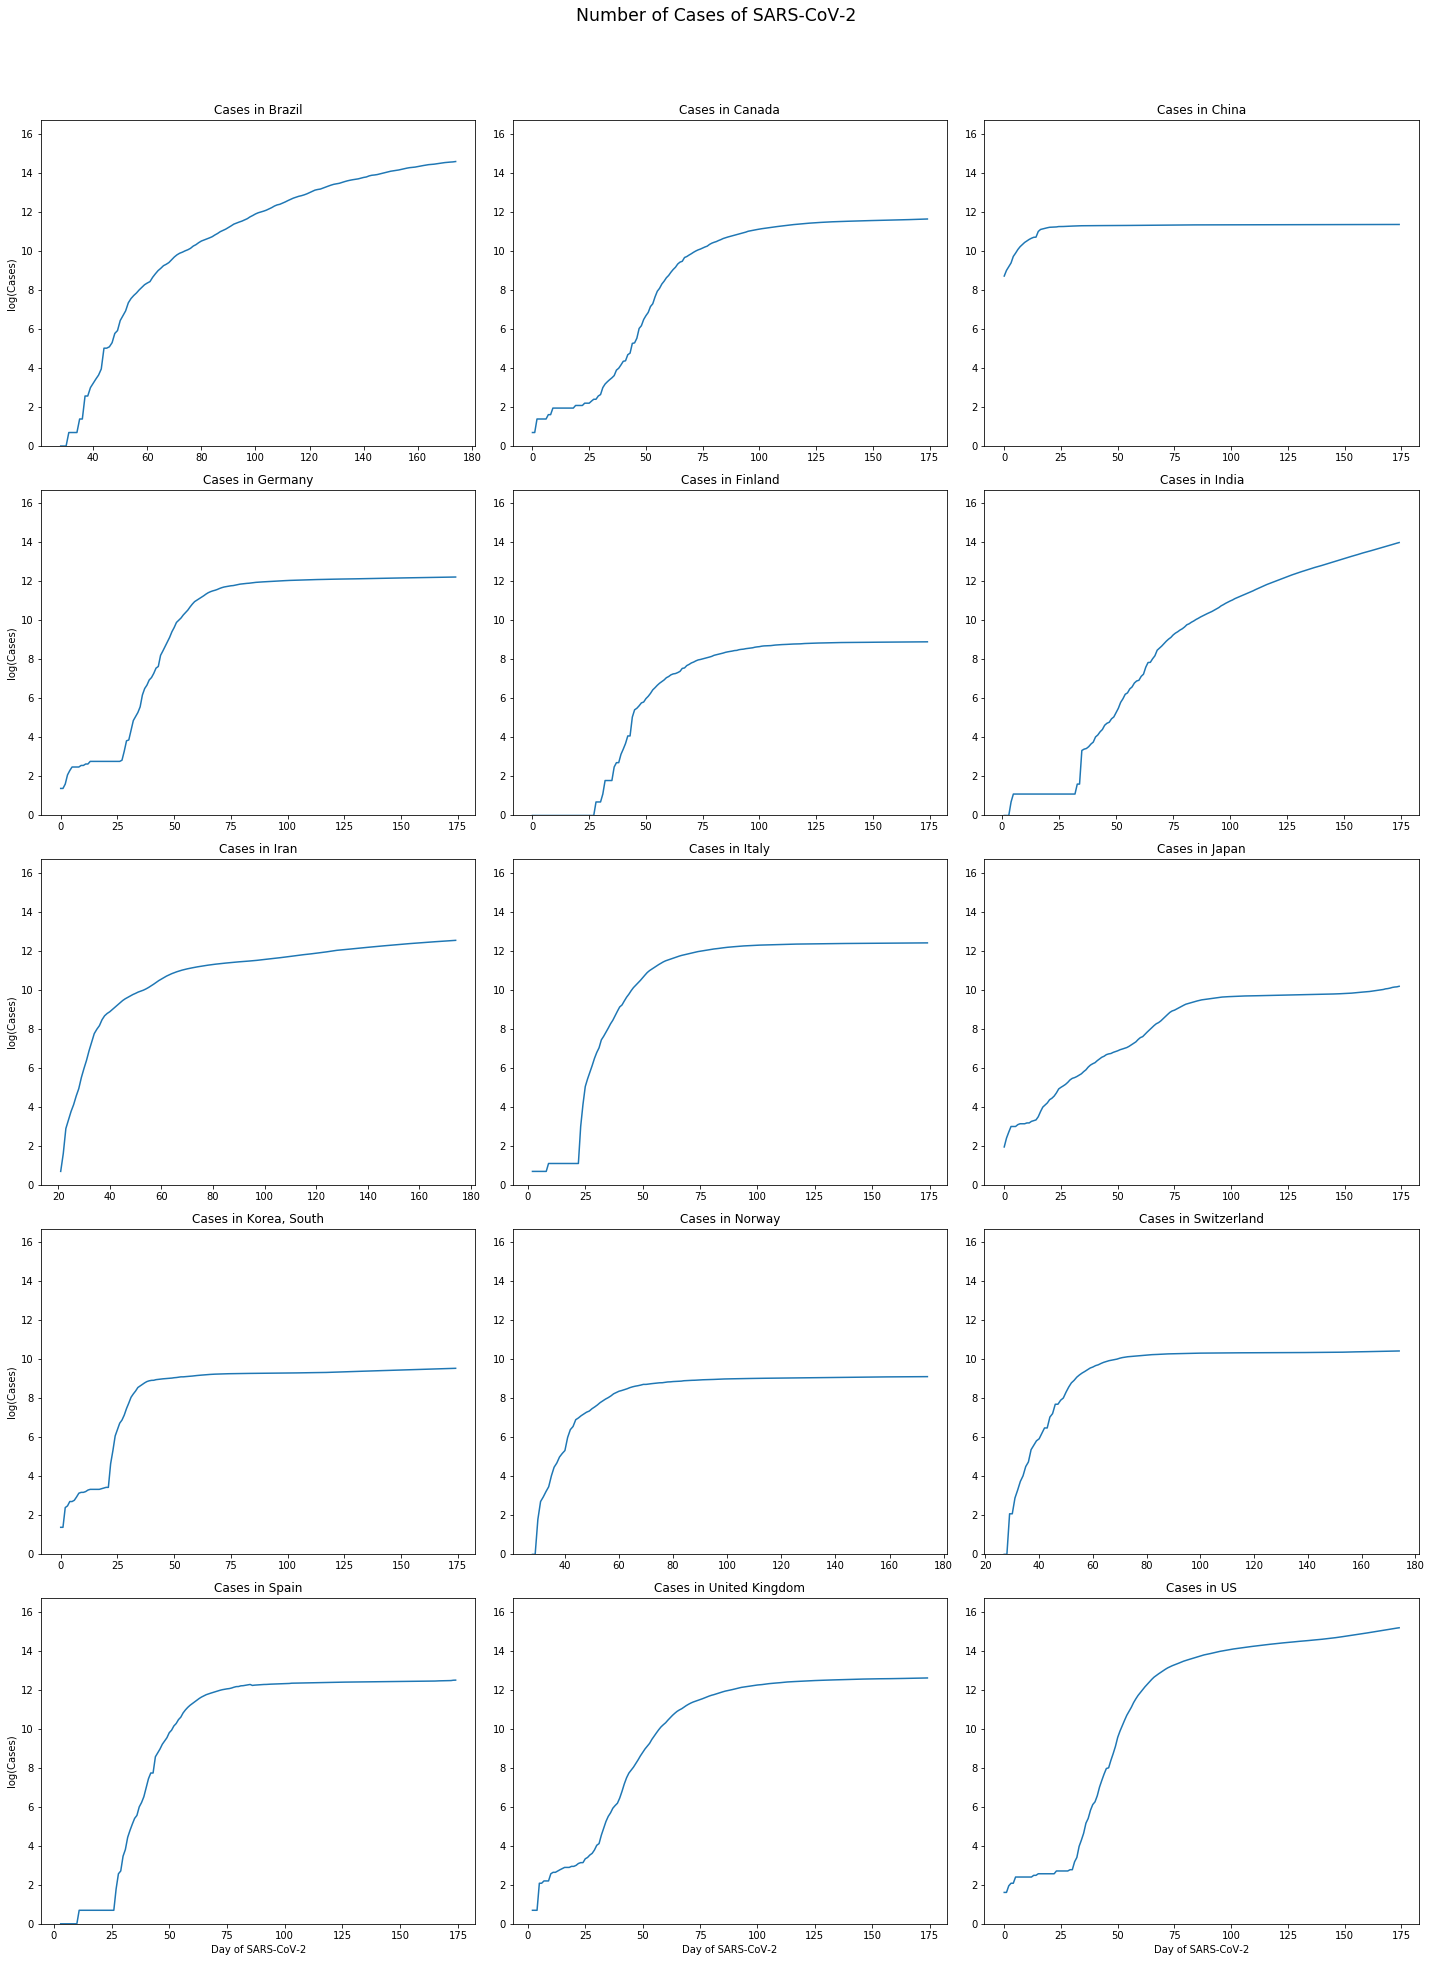

In [20]:
logCases=plotCasesByCountry(countries, logScale=True)

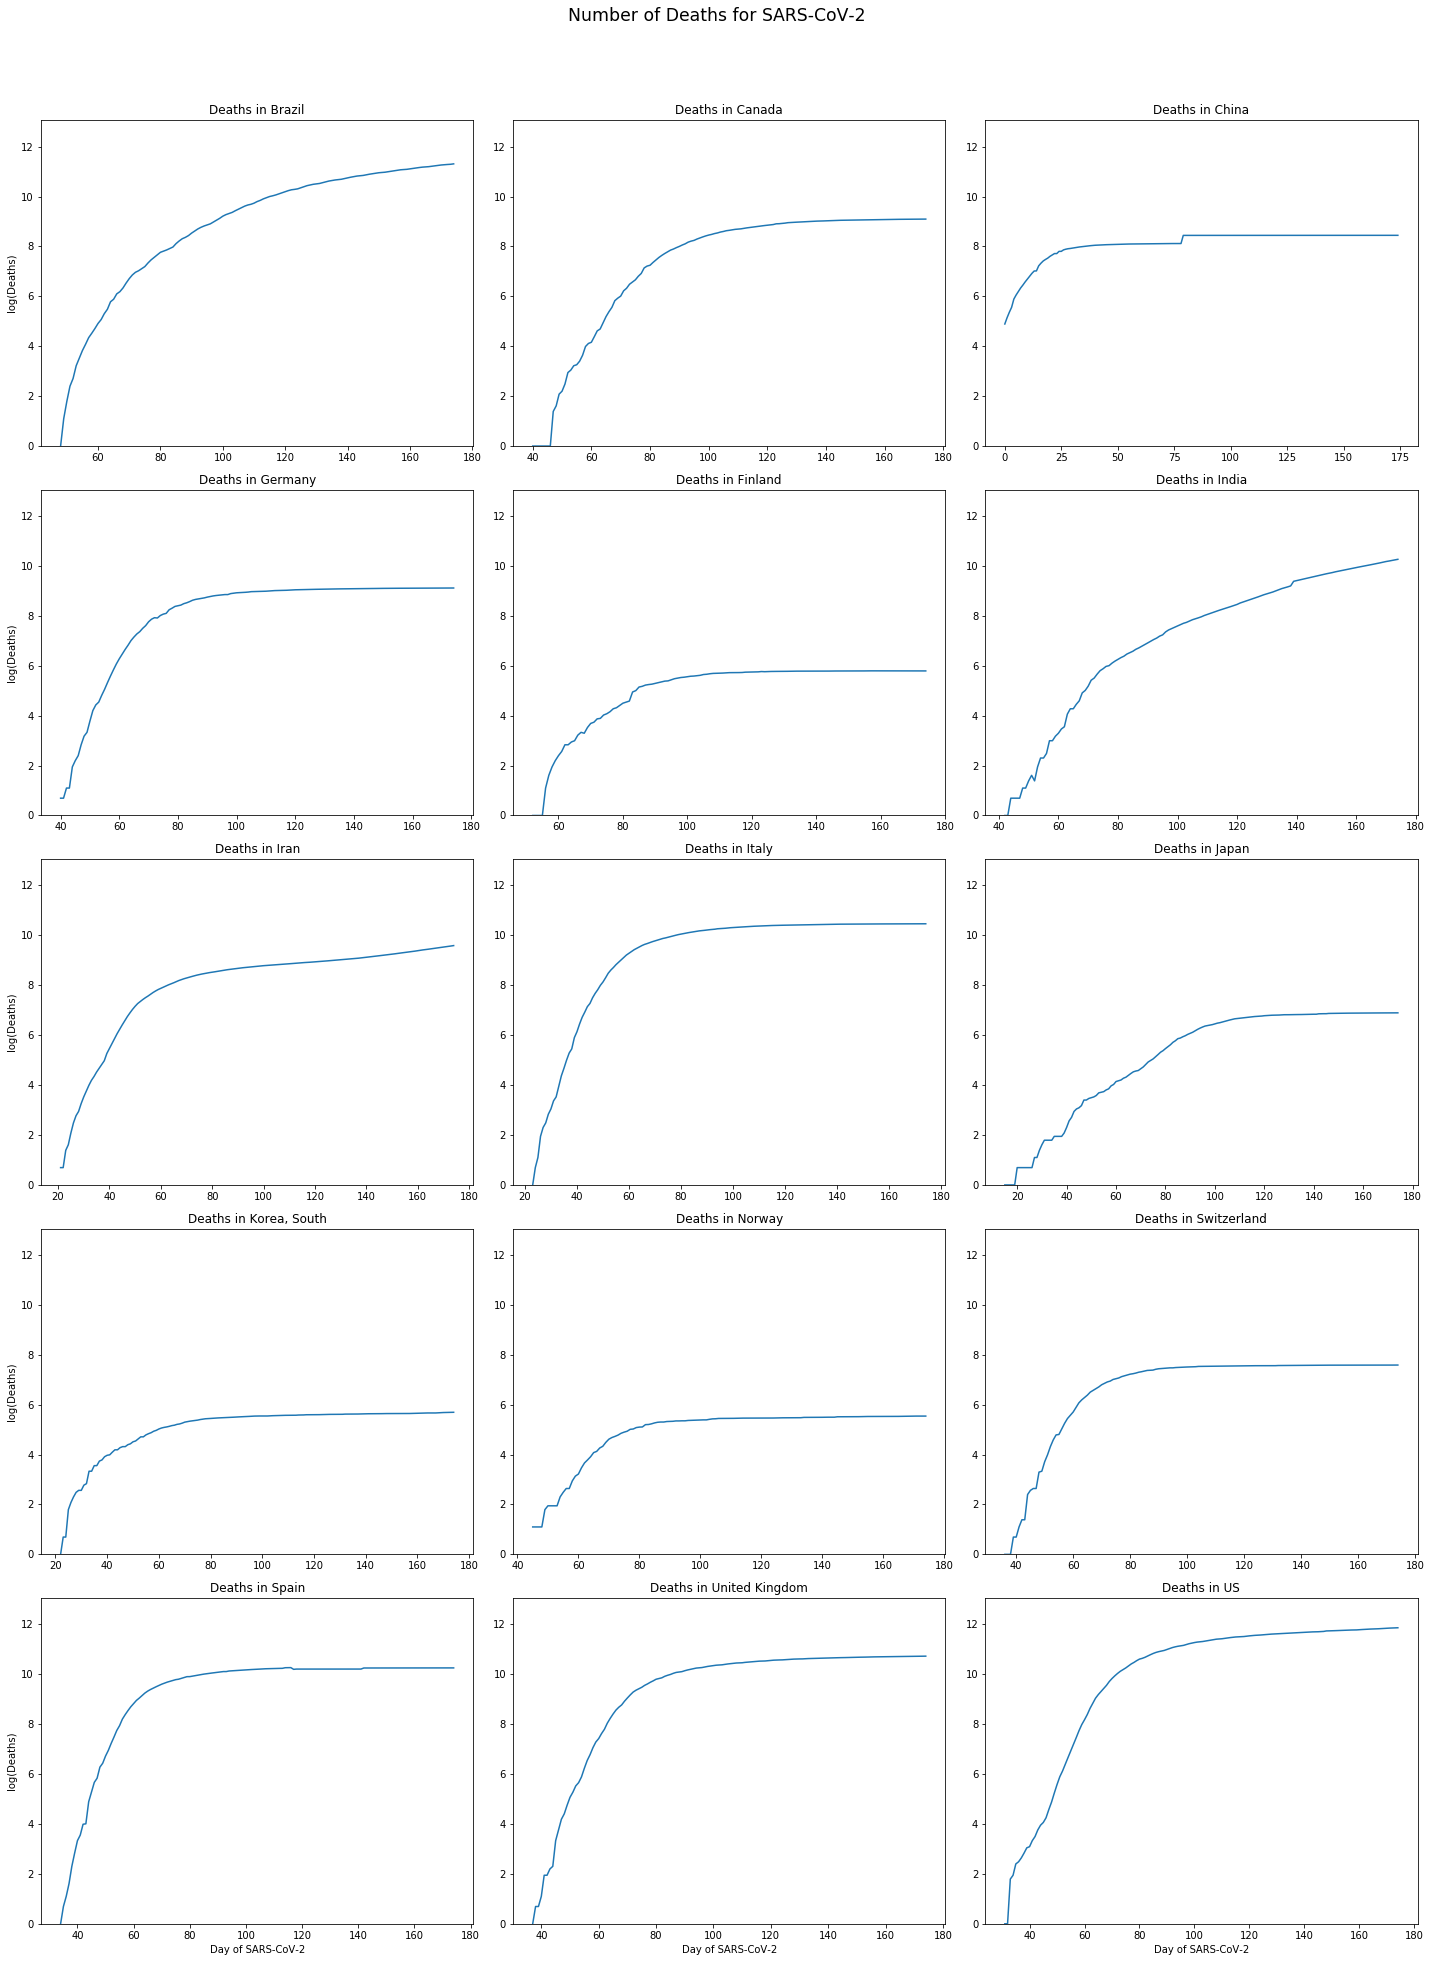

In [21]:
logDeaths=plotDeathsByCountry(countries, logScale=True)

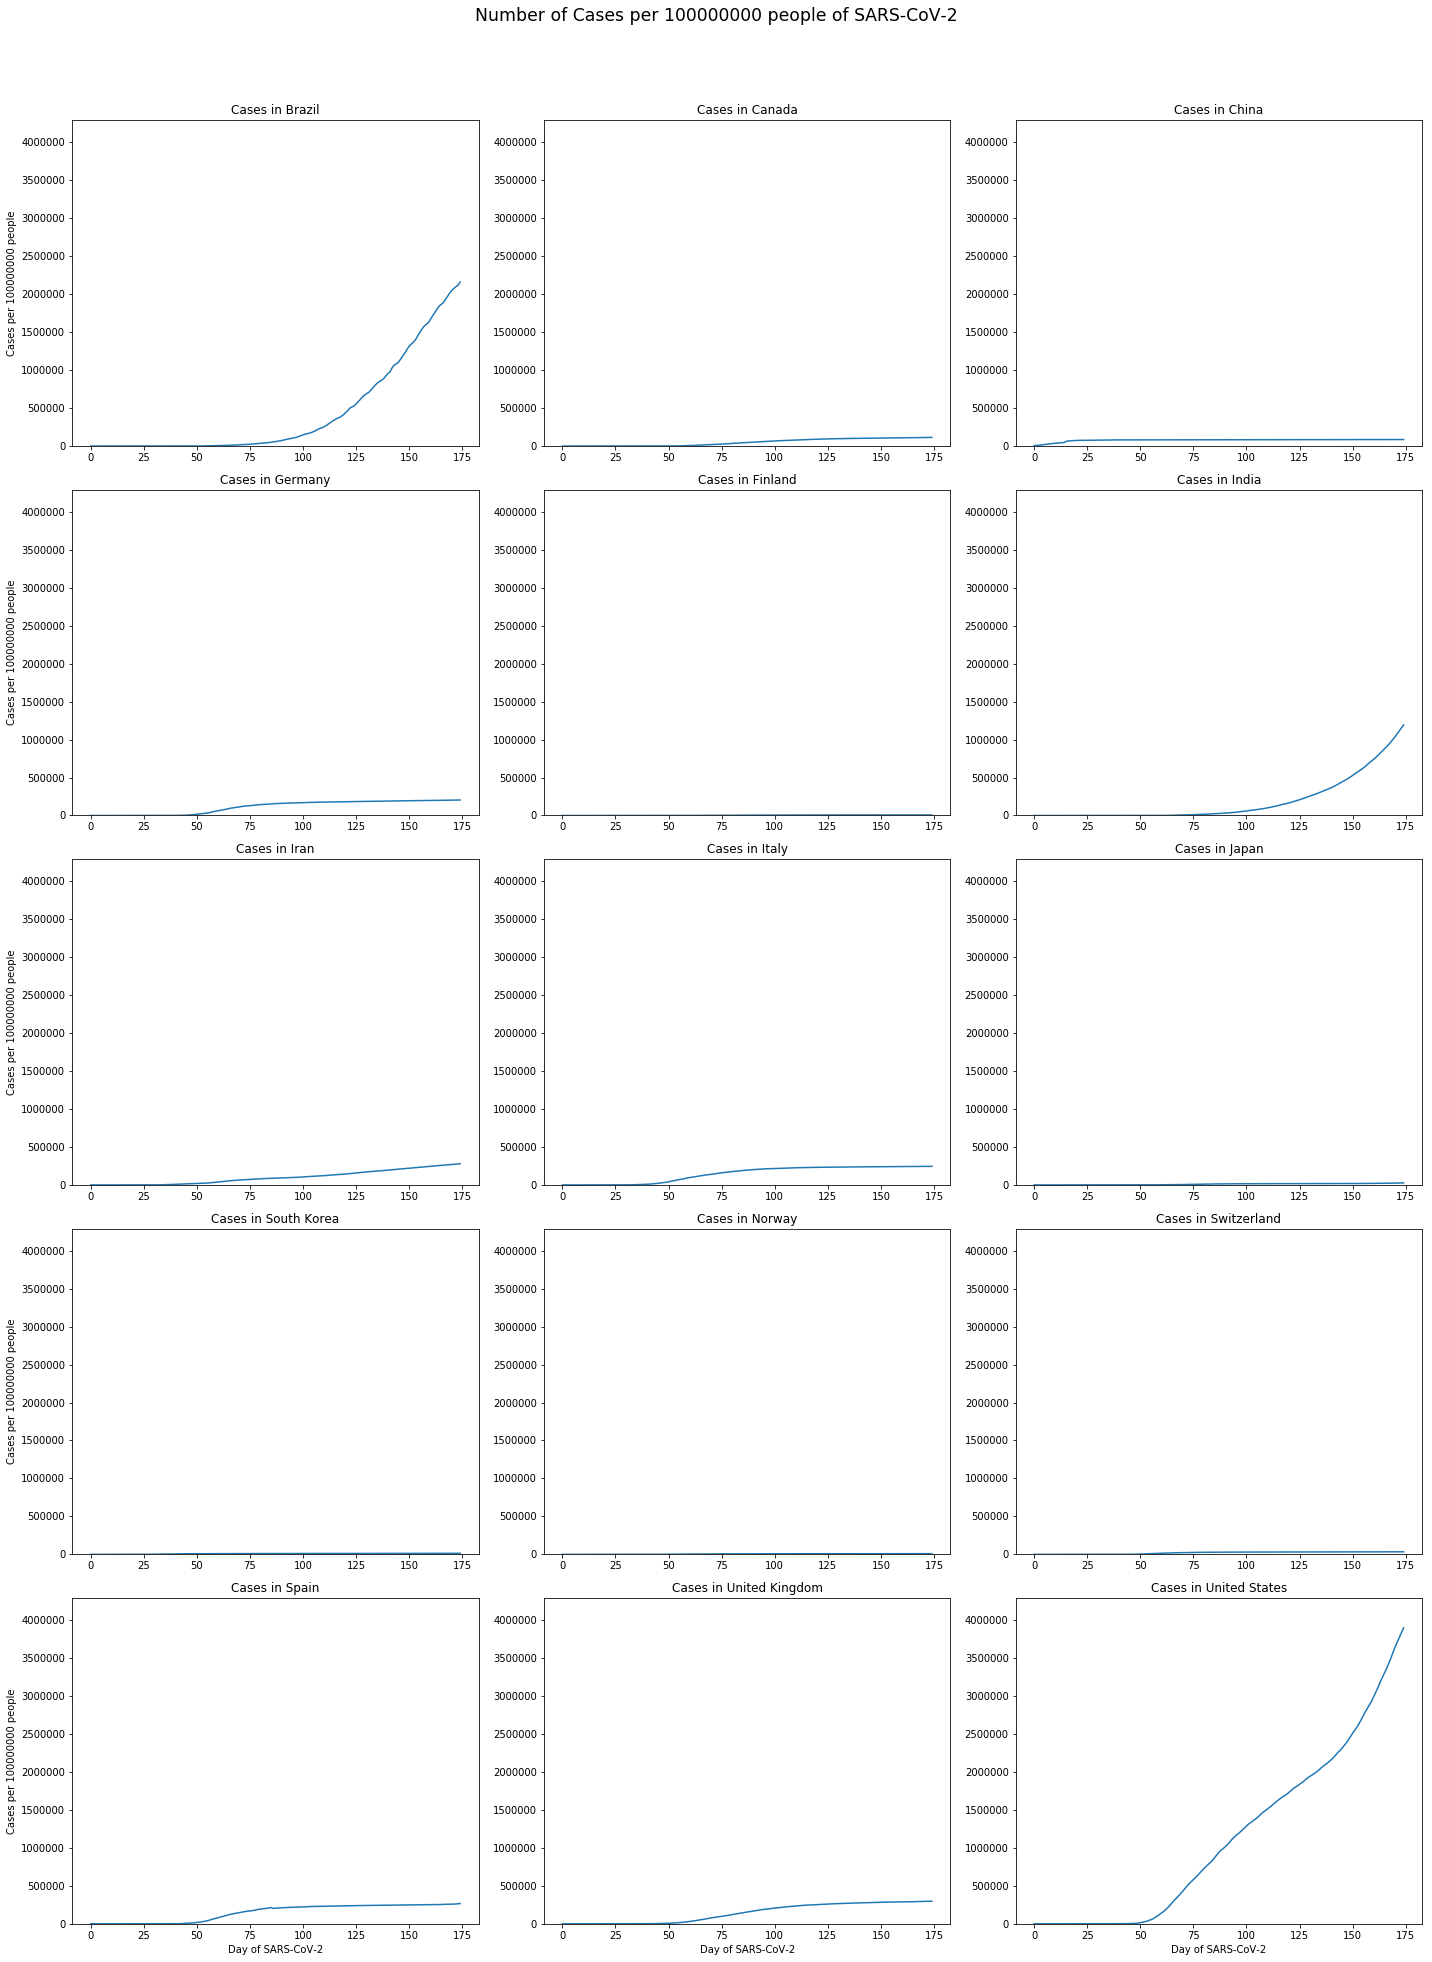

In [56]:
populationDensityCases=plotCasesByCountry(countries, byPopulationDensity=True)

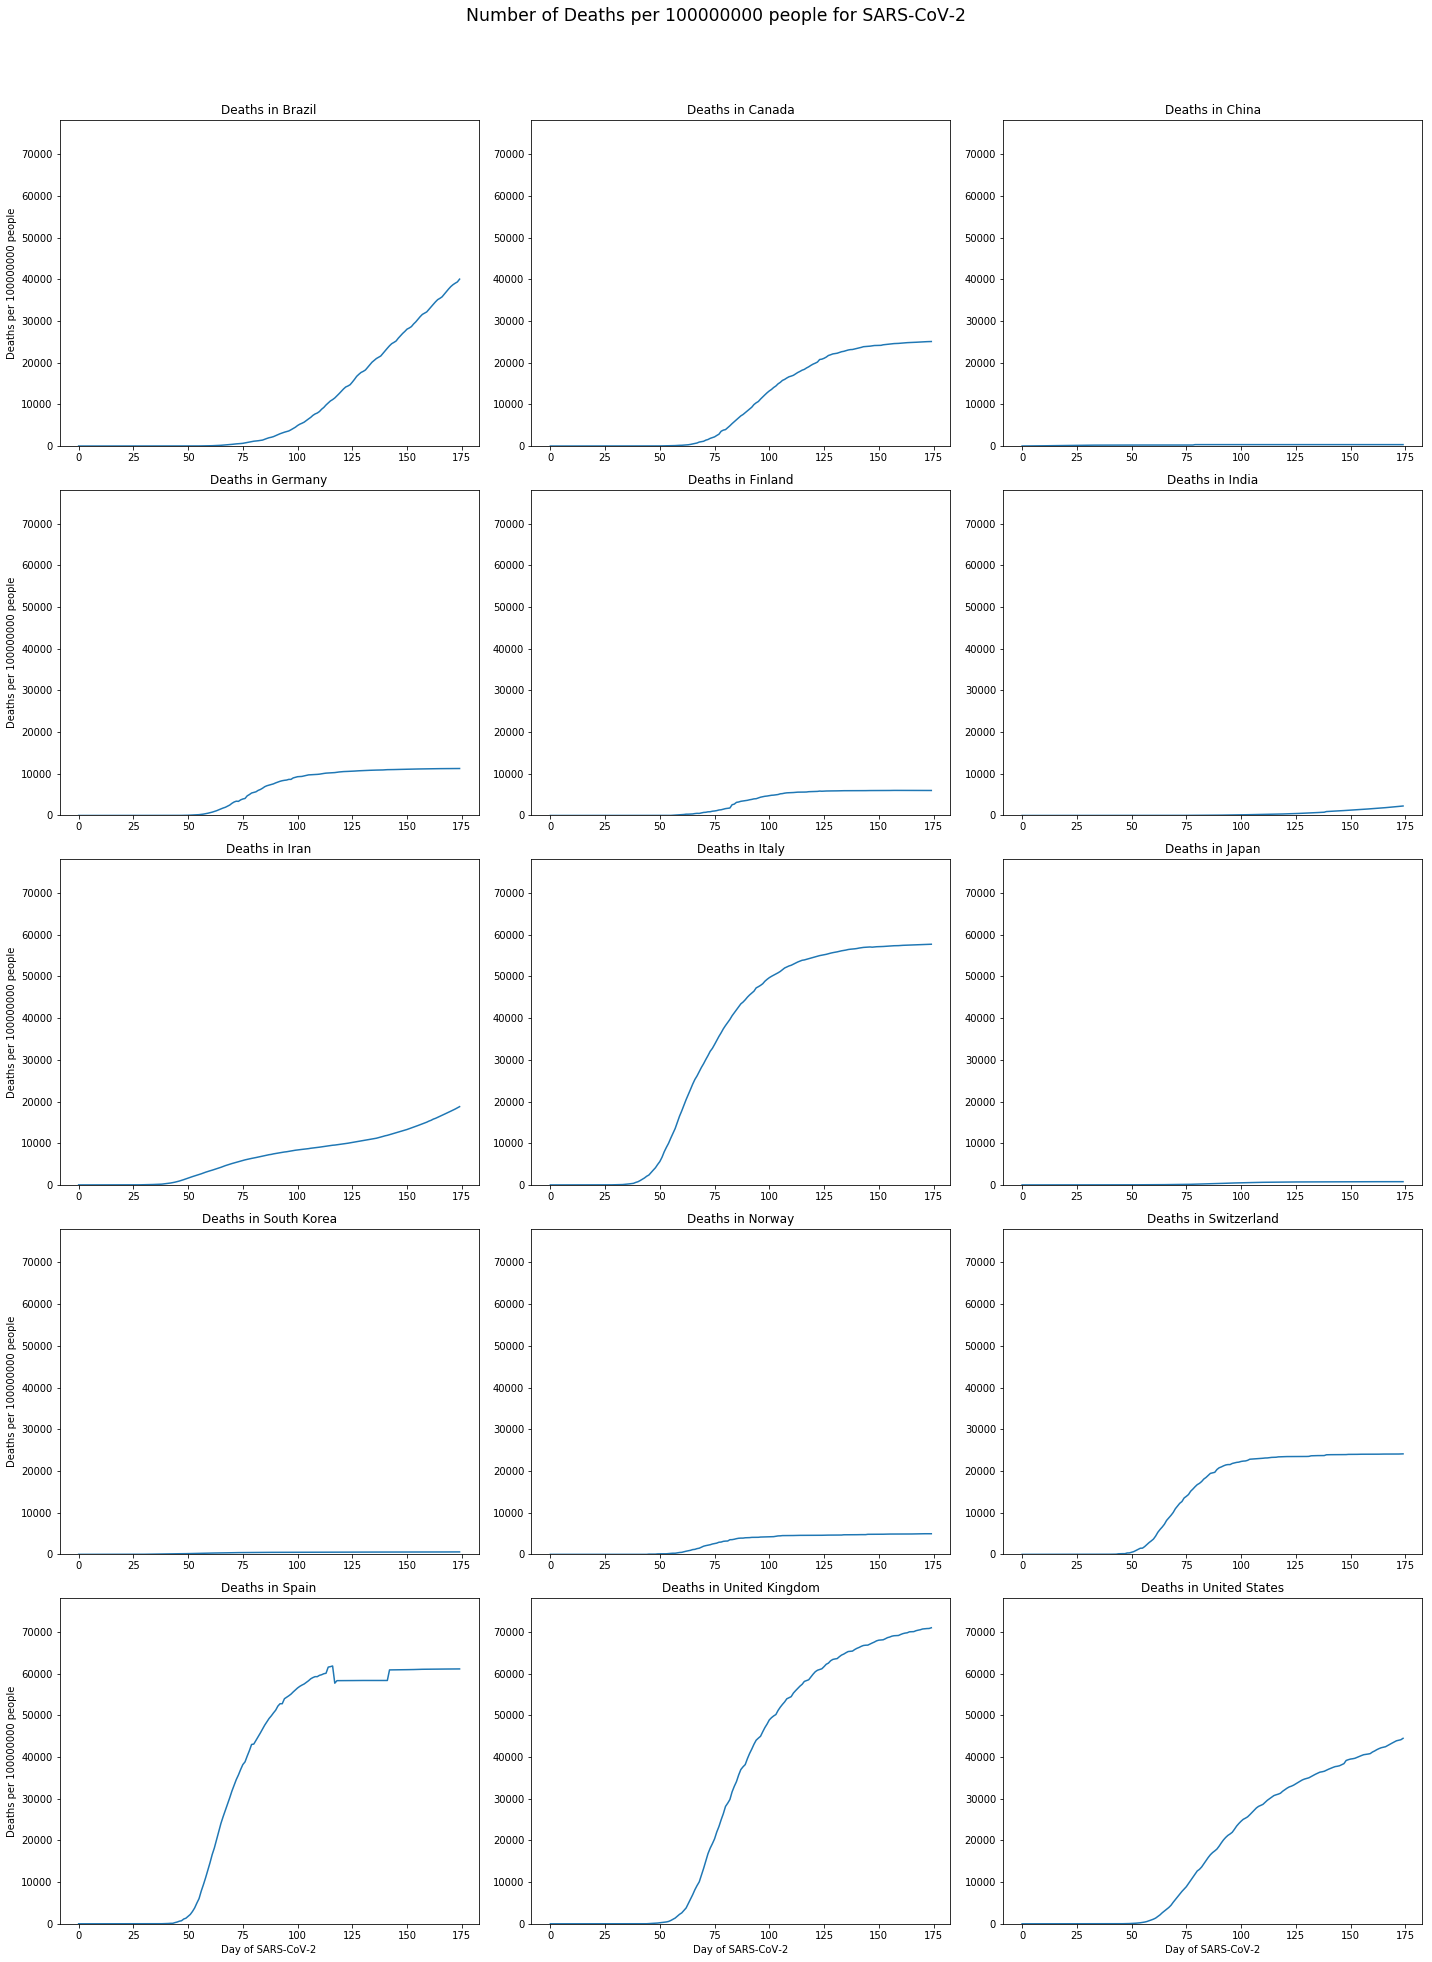

In [57]:
populationDensityDeaths=plotDeathsByCountry(countries, byPopulationDensity=True)

<h4>Observations</h4>

<h3>Daily Reports</h3>
Along with the time series data provided by CSSE, daily reports are provided for the US as well. This data provides more features with hospitalization rates, testing rates and active number of cases for each state. The plots that are shown under this section will run through a similar process as above with the raw data being shown for each state.

In [98]:
dailyReports=r'COVID-19\csse_covid_19_data\csse_covid_19_daily_reports_us\*.csv'

files=glob.glob(dailyReports)
data=[]
for file in files:
    data.append(pd.read_csv(file))
    
df = pd.concat(data, axis=0, ignore_index=True)

In [96]:
df.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470.0,1.0,75.988020,21583.0,437.0,2.610160,84000001.0,USA,460.300152,12.264945
1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,8038.0,31.0,2.941176,84000002.0,USA,1344.711576,11.397059
2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,4.0,48.662422,42109.0,NaN,3.246753,84000004.0,USA,578.522286,NaN
3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,19722.0,130.0,2.109375,84000005.0,USA,761.753354,10.156250
4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155.0,6.0,58.137726,190328.0,5234.0,2.812020,84000006.0,USA,485.423868,22.961176


In [64]:
def getUSPopFromCensusData():
    host="https://api.census.gov/data"
    year="2010"
    dataset="dec/sf1"
    
    base_url="/".join([host,year,dataset])
    
    predicates={}
    
    get_vars=["NAME", "P001001"]
    predicates["get"]=",".join(get_vars)
    predicates["for"]="state:*"
    r=requests.get(base_url, params=predicates)
    
    col_names=["name", "total_pop", "state"]
    
    df=pd.DataFrame(columns=col_names, data=r.json()[1:])
    df["total_pop"]=df["total_pop"].astype(int)
    
    totalPopulation=0
    for population in df.total_pop:
        totalPopulation+=population
        
    return totalPopulation

In [89]:
def plotUSDataDailyReports(data, logScale=False, extrapolateData=False, byPopDensity=False, popDensity=100000, territories=False):
    confirmed=[]
    deaths=[]
    recovered=[]
    active=[]
    mortality=[]
    hospitalRate=[]
    testingRate=[]
    peopleTested=[]
    newCases=[]
    
    if byPopDensity:
        populationSize=getUSPopFromCensusData()
    if territories:
        numStatesAndTerritories=len(us.states.STATES_AND_TERRITORIES)
        statesAndTerroritories=us.states.STATES_AND_TERRITORIES
    else:
        numStatesAndTerritories=len(us.states.STATES)
        statesAndTerroritories=us.states.STATES
    
    if extrapolateData:        
        extrapolateNullValues(data)
    else:
        fillNullValues(data)
    
    for state in statesAndTerroritories:
        if len(confirmed)==0:
            confirmed.append(np.array(data[data.Province_State==state.name].Confirmed))
            deaths.append(np.array(data[data.Province_State==state.name].Deaths))
            recovered.append(np.array(data[data.Province_State==state.name].Recovered))
            active.append(np.array(data[data.Province_State==state.name].Active))
            mortality.append(np.array(data[data.Province_State==state.name].Mortality_Rate))
            hospitalRate.append(np.array(data[data.Province_State==state.name].Hospitalization_Rate))
            testingRate.append(np.array(data[data.Province_State==state.name].Testing_Rate))
            peopleTested.append(np.array(data[data.Province_State==state.name].People_Tested))
        else:
            confirmed+=np.array(data[data.Province_State==state.name].Confirmed)
            deaths+=np.array(data[data.Province_State==state.name].Deaths)
            recovered+=np.array(data[data.Province_State==state.name].Recovered)
            active+=np.array(data[data.Province_State==state.name].Active)
            mortality+=np.array(data[data.Province_State==state.name].Mortality_Rate)
            hospitalRate+=np.array(data[data.Province_State==state.name].Hospitalization_Rate)
            testingRate+=np.array(data[data.Province_State==state.name].Testing_Rate)
            peopleTested+=np.array(data[data.Province_State==state.name].People_Tested)
            
    newCases=deque(confirmed[0].T)
    newCases.rotate(-1)
    newCases.pop()
    newCases.append(0)
    newCases-=confirmed
    newCases=deque(newCases[0].T)
    newCases.pop()
    
    if logScale:
        confirmed=np.log(confirmed)
        deaths=np.log(deaths)
        active=np.log(active)
                
        confirmed[confirmed==math.nan]=0
        deaths[deaths==math.nan]=0
        active[active==math.nan]=0
        
        plt.plot(confirmed.T, label='log(Confirmed Cases)')
        plt.plot(active.T, label='log(Active Cases)')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(deaths.T, label='log(Confirmed Deaths)')
        plt.legend()
        plt.show()
        
        return confirmed, deaths
        
    elif byPopDensity:
        confirmed=popDensity*confirmed.T/populationSize
        deaths=popDensity*deaths.T/populationSize
        active=popDensity*active.T/populationSize
        newCases=popDensity*np.array(newCases).T/populationSize
        peopleTested=popDensity*peopleTested.T/populationSize
        
        plt.plot(confirmed, label='Confirmed Cases per ' + str(popDensity))
        plt.plot(active, label='Active Cases per ' + str(popDensity))
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(newCases, label='New Cases per ' + str(popDensity))
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(deaths, label='Confirmed Deaths per ' + str(popDensity))
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(peopleTested, label='People tested per ' + str(popDensity))
        plt.legend()
        plt.show()
        
        return confirmed, deaths, newCases, peopleTested
        
    else:
        plt.plot(confirmed.T, label='Confirmed Cases')
        plt.plot(active.T, label='Active Cases')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(newCases, label='New Cases')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(deaths.T, label='Confirmed Deaths')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(hospitalRate.T/numStatesAndTerritories, label='Average Hospitalization Rate')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(mortality.T/numStatesAndTerritories, label='Average Mortality Rate(%)')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(testingRate.T/numStatesAndTerritories, label='Average Testing Rate')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(peopleTested.T, label='People tested')
        plt.legend()
        plt.show()
    
        return active,confirmed,deaths,hospitalRate,newCases,testingRate,peopleTested

In [90]:
def fillNullValues(dataFrame):
    dataFrame.loc[dataFrame.Confirmed.isnull(), 'Confirmed']=0
    dataFrame.loc[dataFrame.Active.isnull(), 'Active']=0
    dataFrame.loc[dataFrame.Deaths.isnull(), 'Deaths']=0
    dataFrame.loc[dataFrame.Mortality_Rate.isnull(), 'Mortality_Rate']=0
    dataFrame.loc[dataFrame.Testing_Rate.isnull(), 'Testing_Rate']=0
    dataFrame.loc[dataFrame.Recovered.isnull(), 'Recovered']=0
    dataFrame.loc[dataFrame.Hospitalization_Rate.isnull(), 'Hospitalization_Rate']=0

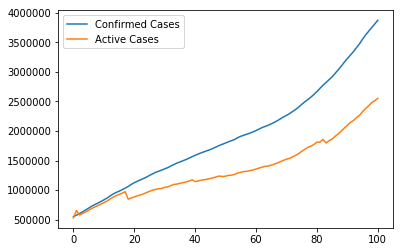

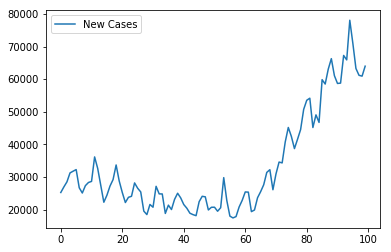

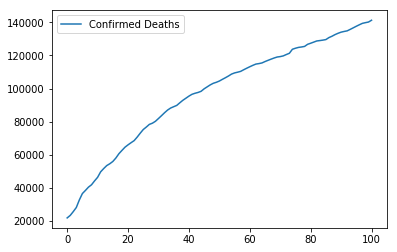

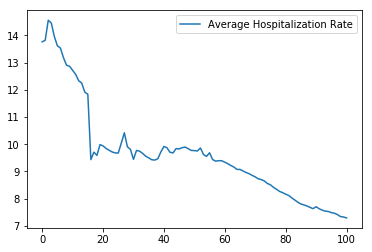

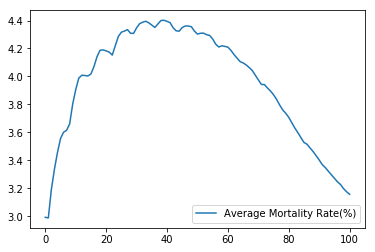

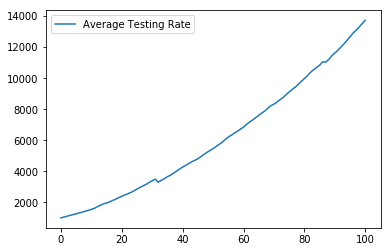

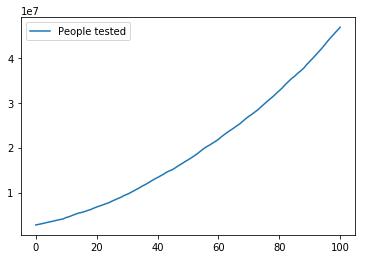

In [92]:
active,confirmed,deaths,hospitalRate,newCases,testingRate,peopleTested=plotUSDataDailyReports(df)

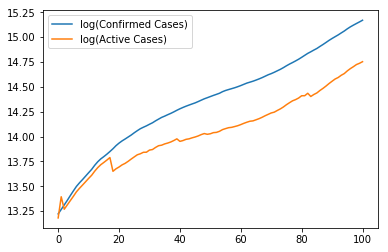

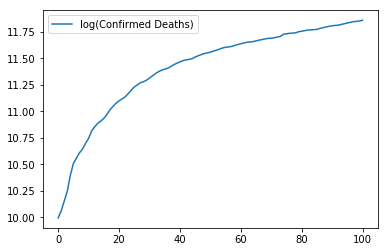

In [265]:
logActive,logConfirmed,logDeaths=plotUSDataDailyReports(df, logScale=True)

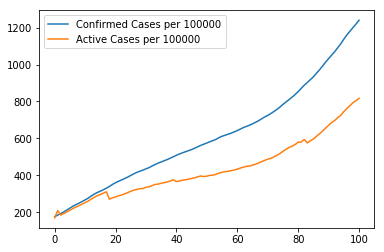

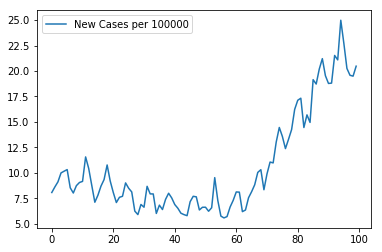

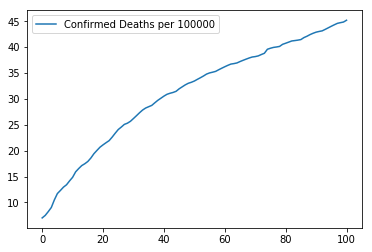

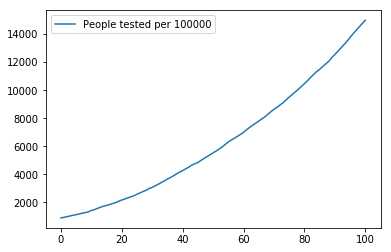

In [78]:
denistyActive,densityConfirmed,densityDeaths,densityPeopleTested=plotUSDataDailyReports(df, byPopDensity=True)

In [102]:
# df[df.Active==0]

<h4>Creating Methods to Process Daily Reports</h4>

<h3>Methods to Create and Display Geographic Heatmap</h3>

<h4>Observations</h4>
<h2>Forecasting Models</h2>
<h3>Models Used</h3>

<h2>Conclusions</h2>